# Math Lectures
### Unit 4 Capstone (Thinkful Data Science)
In this note book we will use common techniques in Natural Language Processing to tokenize the closed captioning of 93 lectures aquired as XML files from the internet.
Project Outline:
 - Process the XML into text (removing html tags)
 - Vectorize each sentence using tf idf and Doc2Vec
 - Calculate the cosine similarity of sentences
 - Use KMeans clustering to cluster the sentences
 - Reduce the dimensionality using t-SNE and PCA
 - Visualize the results
 - Examine the text of the cluster assignments
 - Examine frequency of word use and subject professor density of each cluster
 - Use NMF (non-negative matrix factorization) to extract topics
 - Building a supervised model to predict the subject/professor of the sentence.
 - Compare the results of the two classification methods


In [1]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='mako')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [3]:
#set path to XML files
path = '/root/Desktop/gits/unit-4-NLP-capstone/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
#filenames = [ re.sub('.xml','',i) for i in filenames ]

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [4]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [5]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


filename                                           raw_text
0  aurouxmcalc1  So let's start right away with\nstuff that we ...

### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [6]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [7]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [8]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Differential Equations']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(1)

filename                                           raw_text Professor  \
0  aurouxmcalc1  So let us start right away with stuff that we ...    Auroux   

    Subject  
0  Calculus

### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we will create a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [9]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 3.3962651252746583


In [10]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#explode the df to a new df with each sentence on one line
sentences1 = pd.DataFrame({
         col:np.repeat(sentences[col].values, sentences['sents'].str.len())
         for col in sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(sentences['sents'].values)})[sentences.columns.tolist()]

#get sentence lengths
sentences1['s_len'] = [len(sent) for sent in sentences1.sents]

In [11]:
#check to make sure distribution of attributes to sentences
sentences1.sample(5,random_state=43)

filename Professor     Subject  \
59242         strangmeng5    Strang   Mech. Eng   
11965       devadasalgos3   Devadas  Algorithms   
5335        demainedata15   Demaine        Data   
57511         strangmeng2    Strang   Mech. Eng   
23516  leighton15linearcs  Leighton     CS Math   

                                                    sdoc  \
59242  (   , To, make, a, donation, ,, or, to,    , P...   
11965  (       , PROFESSOR, :, So, today, 's, lecture...   
5335   (       , PROFESSOR, :, All, right, ., Today, ...   
57511  (Your, support, will, help, MIT, OpenCourseWar...   
23516  (  , offer, high, -, quality, educational, res...   

                                                   sents  s_len  
59242                      [-pron-, be, get, zero, will]      5  
11965  [the, reason, interested, algorithm, people, w...      7  
5335                     [but, general, small, power, 2]      5  
57511                   [so, be, differential, equation]      4  
23516                                        [professor]      1

In [12]:
sentences1.shape

(65569, 6)

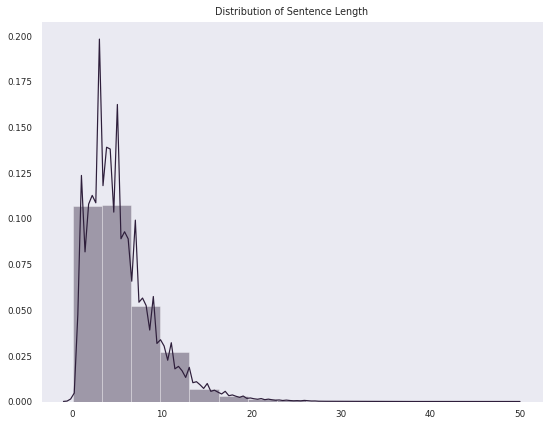

count    65569.000000
mean         5.470649
std          3.800854
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         49.000000
Name: s_len, dtype: float64

In [13]:
plt.figure(figsize=(9,7))
sns.distplot(tuple(sentences1.s_len),bins=15)
plt.title('Distribution of Sentence Length')
plt.show()

sentences1.s_len.describe()

In [14]:
sentences1.shape

(65569, 6)

Currently we have 65000+ sentences that need to be vectorized and processed. In order to avoid complications with the vectorization and clustering, I will set a minimum word length for each sentence.
    
    - Create a list of index numbers to keep
    - Replace the dataframe with only desired index numbers
    - Convert lists of tokens to strings
    - Remove '-pron-' token created by spacy
We've set a window of 9 to 16 sentence size. This will reduce the number of sentences to around 10,000, while hopefully still preserving the substance of the texts.  This is really a compromise. Vectorizing and processing 66,000 sentences is computationally and time intensive, so we want the reduction. Plus, I don't want the model to think sentences like "That's Right" or "Now, what?" or any other short meaningless statement you would hear in a math lecture are more important than longer sentences describing a concept.

In [15]:
#list index numbers to keep
to_keep = [ i for i in sentences1.index if len(sentences1.sents[i]) >= 9 and len(sentences1.sents[i]) <= 16]
#keep index numbers,execute other steps
sentences1 = sentences1.iloc[to_keep]
sentences1['text'] = [' '.join(i) for i in list(sentences1.sents)]
sentences1.text = [ re.sub("-pron-","",sentences1.text[i]) for i in to_keep]
sentences1.reset_index(inplace=True, drop=True) #reset the index here
sentences1.sample(5, random_state=43)

filename Professor     Subject  \
3177  leighton14dandcs  Leighton     CS Math   
6641   rigolletstats19  Rigollet  Statistics   
9408       strangmeng6    Strang   Mech. Eng   
7650       sochernlp13    Socher         NLP   
2590     jerisoncalc21   Jerison    Calculus   

                                                   sdoc  \
3177  (       , PROFESSOR, :, This, week, we, are, g...   
6641  (    , to,    , PROFESSOR, :, ,, bunch, of, x,...   
9408  (   , To, make, a, donation, ,, or, to,    , P...   
7650  ( , Network, ,, there, is, actually, a, whole,...   
2590  (   , To, make, a, donation, ,, or, to,    , P...   

                                                  sents  s_len  \
3177  [all, right, like, know, long, till, world, en...      9   
6641  [think, realization, guy, go, cloud, n, point,...      9   
9408  [so, -pron-, want, sum, square, -pron-, think,...      9   
7650  [well, model, go, see, small, norm, feature, v...     11   
2590  [and, -pron-, think, order, answer, question, ...     12   

                                                   text  
3177        all right like know long till world end t64  
6641        think realization guy go cloud n point r d.  
9408     so  want sum square  think cos(theta sin(theta  
7650  well model go see small norm feature vector z ...  
2590  and  think order answer question  go detail me...

In [16]:
sentences1.shape

(10156, 7)

### Split the data 
 - We need to split the data for training and testing purposes, we will set X as the sentences and Y as the labels to maintain traceability

In [17]:
#Split the data into train and test set.
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

### Tf-Idf Vectorization of the sentences
    Right now we are going to create numerical vectors for each sentence using the Tf-idf feature from the genism library.

In [18]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 15
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )

In [19]:
#Fit vectorizer and transform X_train to vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_train_tfidf_csr = X_train_tfidf.tocsr() #Reshapes the vectorizer output into something people can read
n = X_train_tfidf_csr.shape[0] #number of sentences
tfidf_bysent = [{} for _ in range(0,n)] #A list of dictionaries, one per sentence
terms = vectorizer.get_feature_names() #List of features
#for each sent, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]
print('Original sentence:', X_train[4421],y_train[4421])
print('Tf_idf vector:', tfidf_bysent[4421])

Number of features: 453
Original sentence: after find eigenvalue lambda omega squared know omegas find eigenvector ['Strang' 'Mech. Eng' 'strangmeng10']
Tf_idf vector: {'know': 0.3611194426533281, 'omega': 0.5501703808312975, 'squared': 0.5194008067903516, 'lambda': 0.5450945808749401}


### Calculating the cosine similarity of each sentence 

from wiki:
   " Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. "
https://en.wikipedia.org/wiki/Cosine_similarity

We will use this metric to asses similarity of sentences.

In [20]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
df_similarity = pd.DataFrame(cosine_similarity(X_train_tfidf), index=range(len(X_train)),
                            columns=X_train) # set sentneces as the columns


In [21]:
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

In [22]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [23]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
1672                                           0.709474                         
5563                                           0.702142                         
6827                                           0.686053                         
6662                                           0.649410                         

                                      Original_Sentence Professor  \
4421  after find eigenvalue lambda omega squared kno...    Strang   
1672  and denominator omega nought squared minus ome...   Mattuck   
5563  ay = lambda*y multiply a. a squared*y lambda*a...    Strang   
6827  omega square root omega nought squared minus p...   Mattuck   
6662     omega d omega square plus omega nought squared   Mattuck   

                     Subject       filenames  mean_similarity  
4421               Mech. Eng    strangmeng10         0.013513  
1672  Differential Equations  mattuckdifeq10         0.013710  
5563               Mech. Eng     strangmeng6         0.006807  
6827  Differential Equations  mattuckdifeq10         0.015854  
6662  Differential Equations  mattuckdifeq10         0.012165

### Use PCA to reduce dimensionality and visualize results

In [24]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train_tfidf.todense())

pca_kclusters = pd.DataFrame()
pca_kclusters['original'] = X_train
pca_kclusters['Professor'] = y_train[:,0]
pca_kclusters['Subject'] = y_train[:,1]
pca_kclusters['PCA_1'] = Y[:,0]
pca_kclusters['PCA_2'] = Y[:,1]
pca_kclusters['filename'] = y_train[:,2]
df_similarity['PCA_1'] = Y[:,0]
df_similarity['PCA_2'] = Y[:,1]

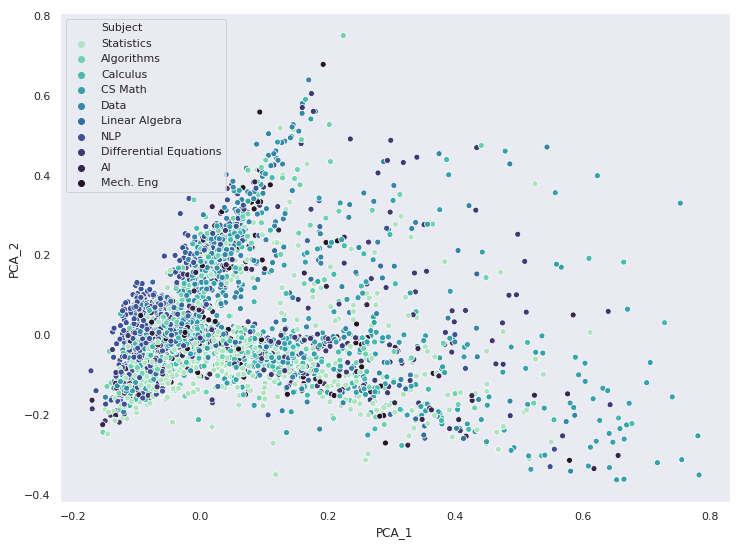

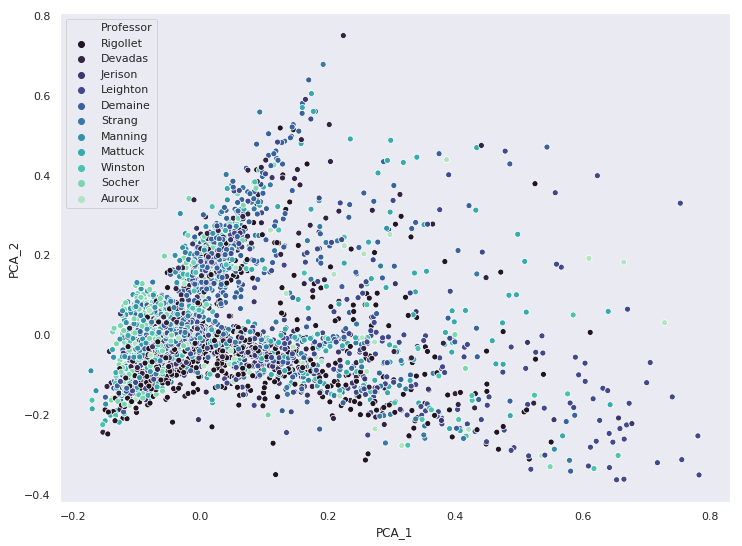

In [25]:
sns.set_context('notebook')
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Subject',data=pca_kclusters,palette='mako_r')
plt.show()
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Professor',data=pca_kclusters,palette='mako')
plt.show()

Now that the dimension has been reduced to two, we can scatter the results and color the cluster label, for a given number of clusters.
I chose the folowing as the number of clusters to test [5, 6, 7, 8, 9, 10, 11, 25, 93]. 
10,11,93 because it is the number of professors,subjects,lectures respectively.
For good measure I try 5 (lower than the desired cluster amount) and 25 (higher than the desired number).


The desired number of clusters is based on number of subjects and number of professors. >> 10 or 11

### KMeans Clustering

We will iterate over the list of cluster numbers, clustering and plotting the two PCA components with the correst cluster assignment as the hue of each point.

Number of Clusters: 5

Silhouette avg 5 clusters: 0.47284726176928116




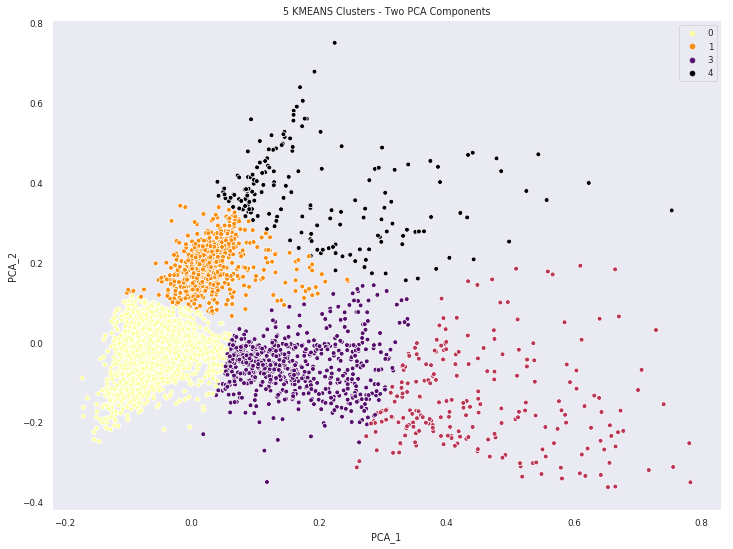

Number of observations per cluster:
0    5858
3     692
1     637
2     252
4     178
dtype: int64
Time: 2.298261880874634 seconds.

Number of Clusters: 6

Silhouette avg 6 clusters: 0.059313736716412




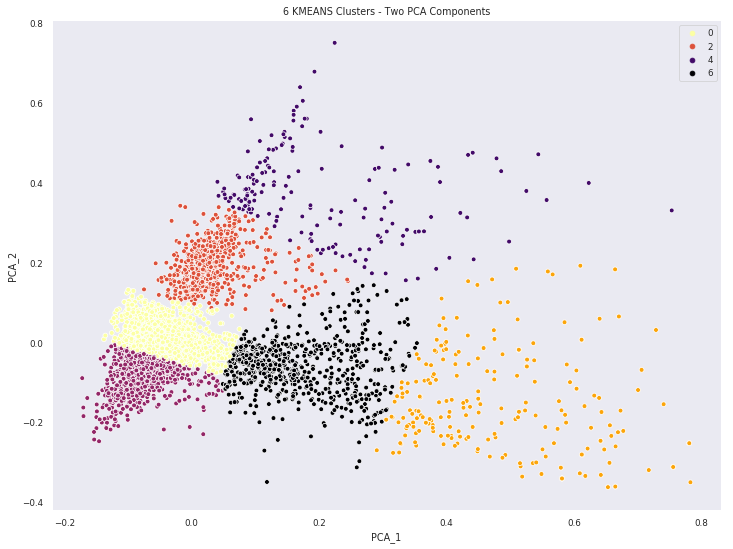

Number of observations per cluster:
0    4367
3    1552
5     676
2     624
1     227
4     171
dtype: int64
Time: 1.9685511589050293 seconds.

Number of Clusters: 7

Silhouette avg 7 clusters: 0.07919678792341367




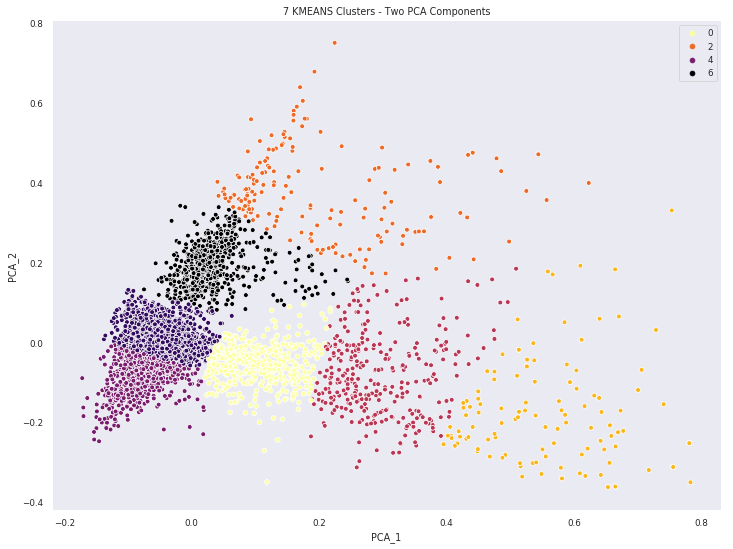

Number of observations per cluster:
5    4324
4    1466
6     624
0     577
3     321
2     172
1     133
dtype: int64
Time: 2.178875684738159 seconds.

Number of Clusters: 8

Silhouette avg 8 clusters: 0.03705395103438007




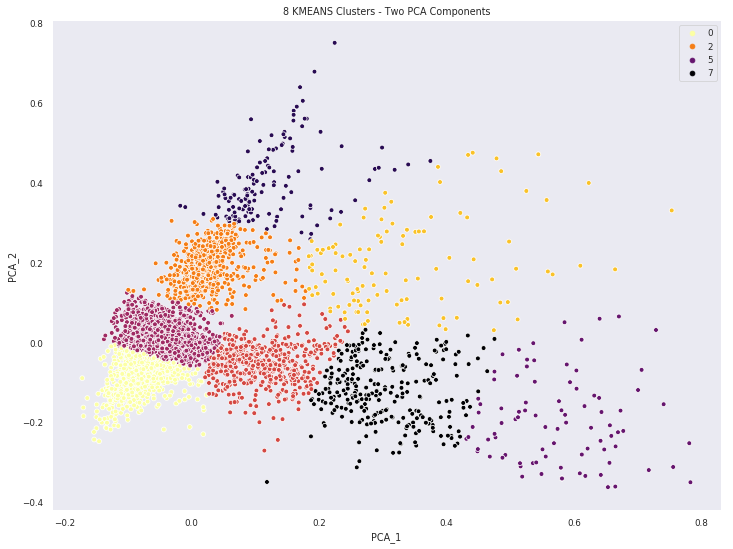

Number of observations per cluster:
4    4321
0    1474
2     593
3     585
7     277
6     137
1     119
5     111
dtype: int64
Time: 2.2089133262634277 seconds.

Number of Clusters: 9

Silhouette avg 9 clusters: 0.0029371846169960673




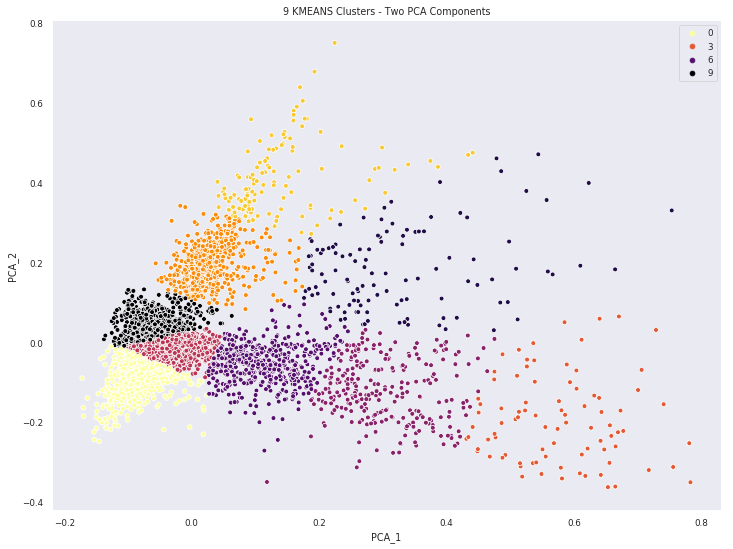

Number of observations per cluster:
4    3615
0    1144
8    1066
2     583
6     577
5     277
1     126
7     118
3     111
dtype: int64
Time: 2.3583052158355713 seconds.

Number of Clusters: 10

Silhouette avg 10 clusters: -0.029275306126885586




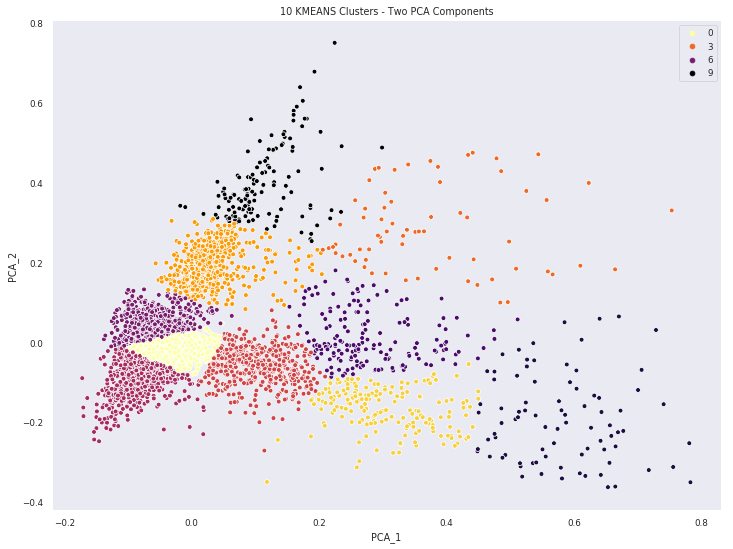

Number of observations per cluster:
0    3608
5    1133
6    1076
2     577
4     546
1     194
7     174
9     131
8     107
3      71
dtype: int64
Time: 2.3140690326690674 seconds.

Number of Clusters: 11

Silhouette avg 11 clusters: -0.0399978626682901




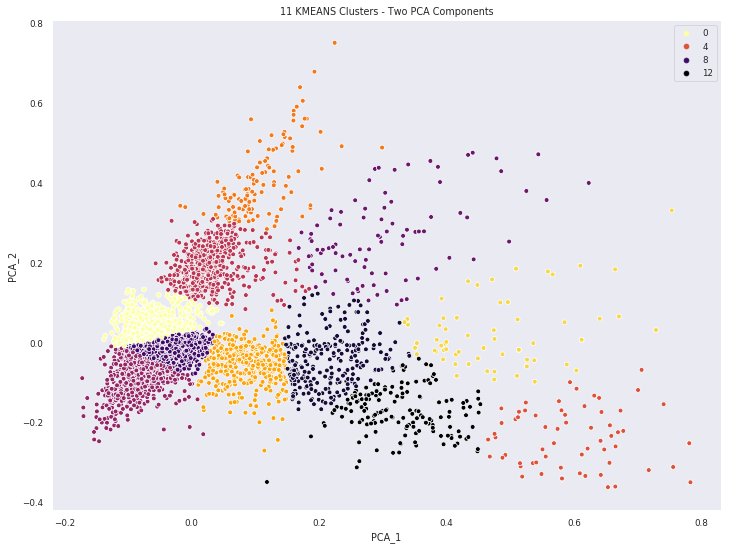

Number of observations per cluster:
8     3596
6     1133
0     1058
5      570
2      480
9      254
10     164
3      123
7       94
4       78
1       67
dtype: int64
Time: 2.363818883895874 seconds.

Number of Clusters: 25

Silhouette avg 25 clusters: -0.23619697629830114




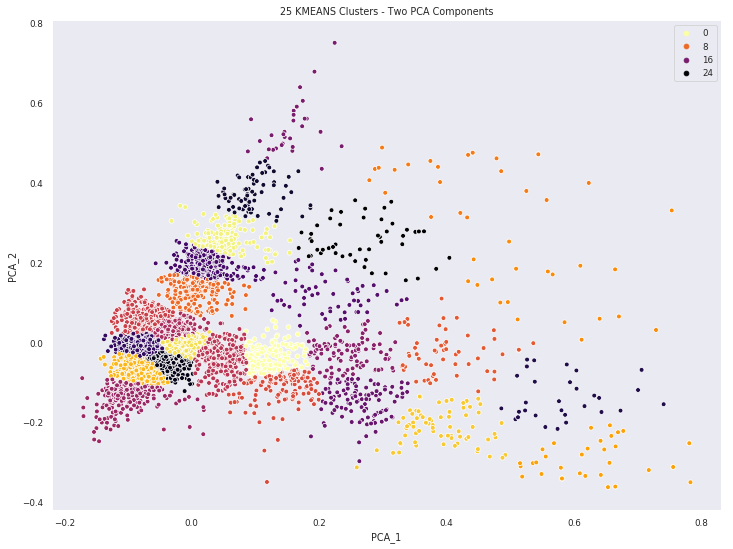

Number of observations per cluster:
2     1607
20    1168
23     881
13     777
4      678
11     321
12     299
19     261
14     261
0      199
8      196
1      163
dtype: int64
Time: 2.92950439453125 seconds.

Number of Clusters: 93

Silhouette avg 93 clusters: -0.43188499040744993




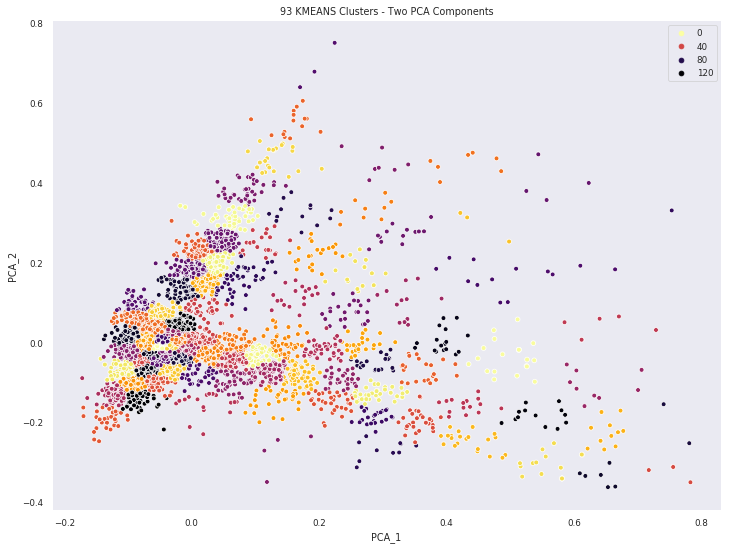

Number of observations per cluster:
10    522
28    476
74    431
0     414
62    313
87    295
68    282
51    242
55    237
23    221
19    212
40    203
dtype: int64
Time: 5.184279918670654 seconds.



In [26]:
sns.set_context('paper')
k_clusters = [5,6,7,8,9,10,11,25,93]
for i in k_clusters:
    t1 = time.time()
    modelk_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_score(Y, modelk_clusters, metric='cosine'))
    print('\n')
    pca_kclusters['cluster_k='+str(i)] = modelk_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue=modelk_clusters, data=pca_kclusters,palette='inferno_r')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} KMEANS Clusters - Two PCA Components".format(i))   
    plt.show()    
    print('Number of observations per cluster:')
    print(pd.value_counts(modelk_clusters)[:12])
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

Visualize the text of a random cluster

In [27]:
t22 = time.time()

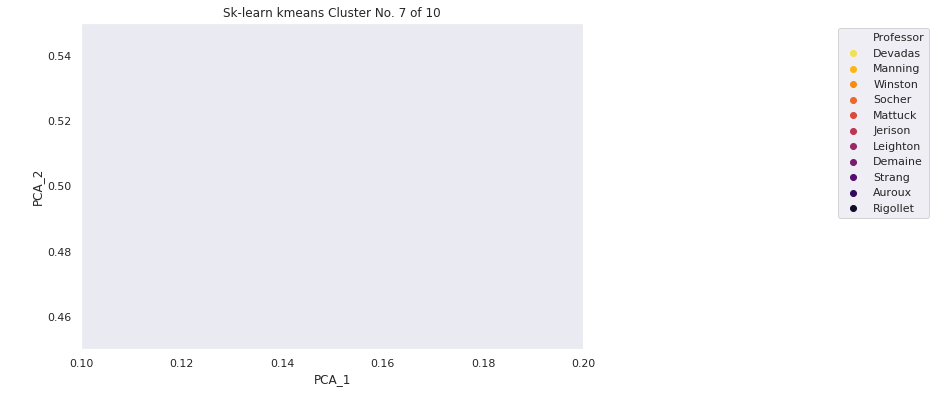

In [28]:
cluster6 = pca_kclusters[pca_kclusters['cluster_k=10'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_kclusters[pca_kclusters['cluster_k=10'] == 6],
                palette='inferno_r')
for label, x, y in zip(cluster6.original,cluster6.PCA_1,cluster6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(.1,.2)
plt.ylim(.45,.55)
plt.title('Sk-learn kmeans Cluster No. 7 of 10')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()    


So far its hard to tell what the algorithm is doing. The silhouette scores are pretty horrible. They range from .5 to -.47. A large loss in score occurs between 5 and 6 clusters. For this cluster at least almost every sentence contains the word 'time.'

### Vectorization of Sentences with Doc2Vec
Learn paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”.

The algorithms use either hierarchical softmax or negative sampling; see Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: “Efficient Estimation of Word Representations in Vector Space, in Proceedings of Workshop at ICLR, 2013” and Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean: “Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013”.
https://radimrehurek.com/gensim/models/doc2vec.html

When training a Doc2Vec model, both word representations and paragraph representations are stored. Using the vector representation of each sentence in the model, we can then attempt to cluster the data again and compare the results with our tf-idf vectors. 

#### Important features of the Doc2Vec Class
    -Word2VecKeyedVectors – This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways.
    
    - Doc2VecKeyedVectors – This object contains the paragraph vectors. Remember that the only difference between this model and Word2Vec is that besides the word vectors we also include paragraph embeddings to capture the paragraph.

    In this way we can capture the difference between the same word used in a different context. For example we now have a different representation of the word “leaves” in the following two sentences

    1. Manos leaves the office every day at 18:00 to catch his train
    2. This season is called Fall, because leaves fall from the trees.

    In a plain Word2Vec model the word would have exactly the same representation in both sentences, in Doc2Vec it will not.


In [29]:
#Split the data exactly the way it was previously split
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [30]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [31]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [32]:
#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("math_lects2.model")
print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [33]:
#load the saved model
model= Doc2Vec.load("math_lects2.model")

In [34]:
X_train.shape

(7617,)

In [35]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[4421])
print(model.docvecs['4421'])

TaggedDocument(['after', 'find', 'eigenvalue', 'lambda', 'omega', 'squared', 'know', 'omegas', 'find', 'eigenvector'], ['4421'])
[-1.4406817e+00  1.8245621e+00  1.2832012e+00 -5.8029586e-01
  8.5084838e-01 -1.3549311e+00  1.3782665e+00  1.0957455e-01
  4.3240145e-02 -2.5019708e+00  5.0492853e-01 -1.3457863e+00
  3.4345429e-02 -1.4104494e+00 -1.0549458e+00 -2.0052780e-01
 -8.6668022e-02 -4.0750023e-02 -1.0228305e+00 -4.3210376e-02
  9.2049056e-01  1.2359617e+00 -5.1117665e-01  9.9299431e-01
  8.9277506e-01  2.3770703e-01  1.2383003e+00  4.0100673e-01
 -1.8799584e-01  2.1996944e+00  4.9954318e-03  2.1252649e-01
 -3.1175587e-01 -1.7788560e+00 -2.7412841e-01  1.0758486e+00
  3.2354537e-01 -4.0505618e-02  5.4125428e-02  8.1592518e-01
  1.1822952e+00  8.1651056e-01  1.8331554e+00  1.5456893e+00
  1.3286408e+00  2.1476228e+00  4.8988976e-02 -6.6385972e-01
 -9.4399476e-01 -1.5931833e+00 -1.3206005e-01  1.8614317e+00
  3.5543317e-01 -1.9140049e+00  1.9424978e+00  1.0339739e+00
 -8.3944559e-01  

In [36]:
vecs.shape

(7617, 100)

In [37]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [38]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_sim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_sim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [39]:
#add identification to similarity dataframe
d2v_sim['Professor'] = y_train[:,0]
d2v_sim['Subject'] = y_train[:,1]
d2v_sim['Original_Sentence'] = X_train
d2v_sim['filenames'] = y_train[:,2]

In [40]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
5852                                           0.574568                         
4808                                           0.574293                         
3807                                           0.529872                         
6607                                           0.516844                         

                                      Original_Sentence Professor     Subject  \
4421  after find eigenvalue lambda omega squared kno...    Strang   Mech. Eng   
5852   know tn bar converge 1 lambda  know 1 tn bar ...  Rigollet  Statistics   
4808  so implicit differentiation technique allow di...   Jerison    Calculus   
3807  now know tie lie near plane different sens cur...    Socher         NLP   
6607  and eigenvector know large carry large varianc...  Rigollet  Statistics   

            filenames  mean_similarity  
4421     strangmeng10         0.134023  
5852    rigolletstat2         0.215678  
4808     jerisoncalc5         0.173987  
3807       sochernlp3         0.146324  
6607  rigolletstats19         0.185333

We  can see that the similar sentences in the Doc2Vec model differ from those in the TFIDF similarity matrix.  A noticable difference is the TFIDF vectors tend to be more similary based on word frequency (as expected). In the first similarity comparison for sentence 4421, we can see that the most similar sentences are those with 'omega'. However in the Doc2Vec it appears to be incorporating multiple words. In the results directly above, we can see that the most similar sentences contains the word 'find' followed by other sentences that contain various words from the benchmark sentence (eigenvector and lambda)

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [41]:
vecs.shape

(7617, 100)

In [42]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

Number of Clusters: 5

Silhouette Score 5 clusters: 0.2568813195298038




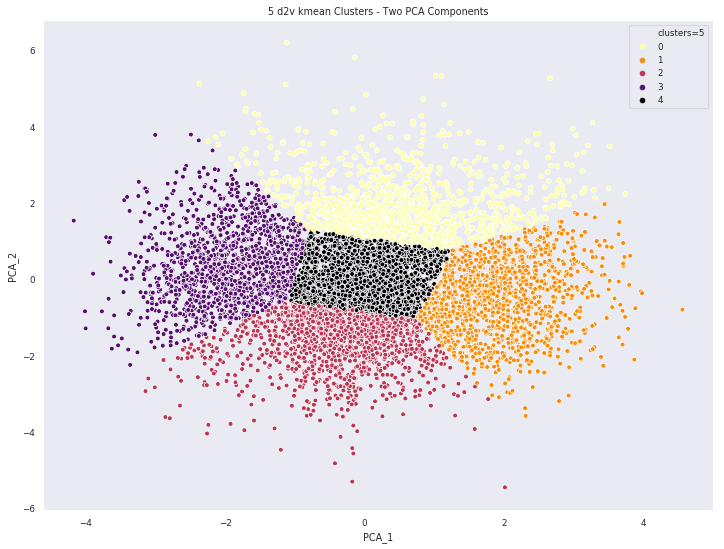


Avg Obs per cluster: 1523.4

Number of observations per cluster:
4    2251
2    1417
3    1385
1    1341
0    1223
dtype: int64
Time: 2.3573780059814453 seconds.

Number of Clusters: 7

Silhouette Score 7 clusters: 0.2238985906210075




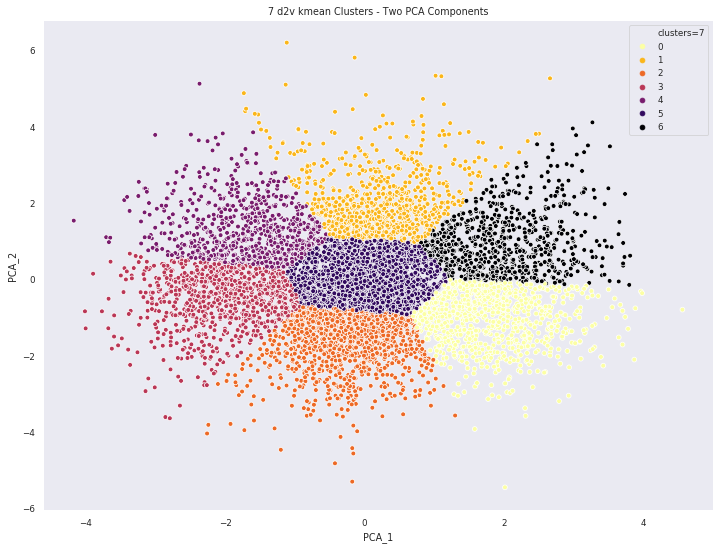


Avg Obs per cluster: 1088.142857142857

Number of observations per cluster:
5    2178
2    1230
0     922
3     898
1     864
4     764
6     761
dtype: int64
Time: 2.5367531776428223 seconds.

Number of Clusters: 9

Silhouette Score 9 clusters: 0.06128007441764374




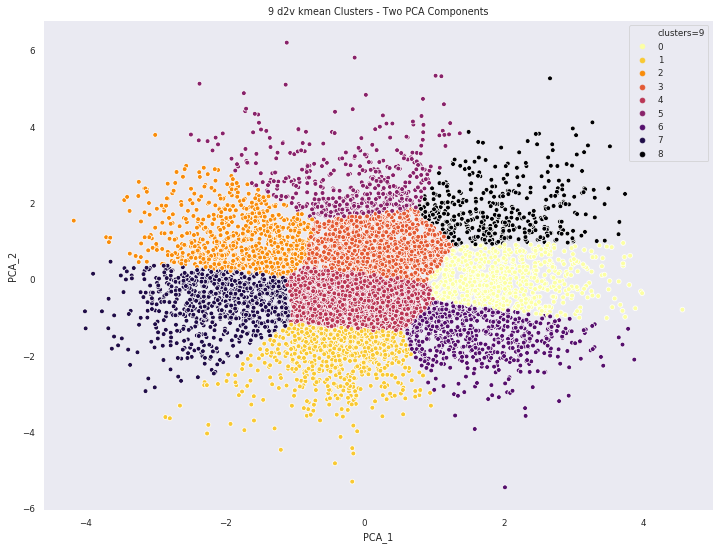


Avg Obs per cluster: 846.3333333333334

Number of observations per cluster:
4    1811
3    1317
2     777
7     764
0     758
1     718
6     603
5     463
8     406
dtype: int64
Time: 2.5665907859802246 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.025904481890761822




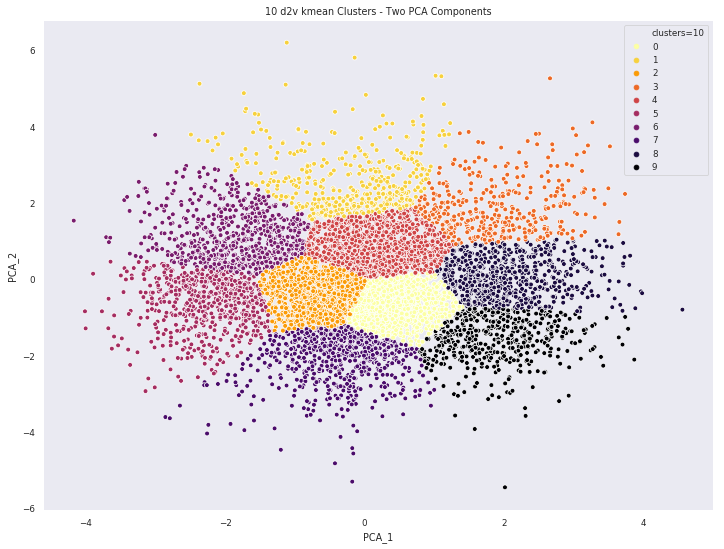


Avg Obs per cluster: 761.7

Number of observations per cluster:
4    1297
0    1158
2    1116
6     716
8     707
7     659
5     639
9     474
1     450
3     401
dtype: int64
Time: 2.7856786251068115 seconds.

Number of Clusters: 11

Silhouette Score 11 clusters: 0.0005807142585774546




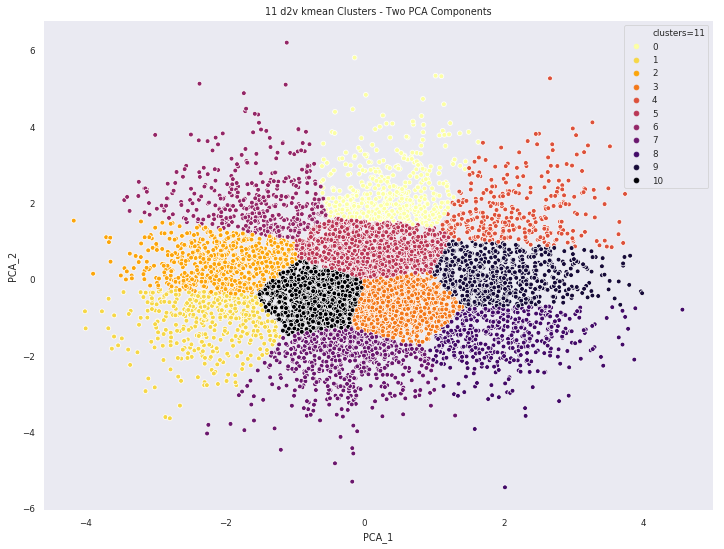


Avg Obs per cluster: 692.4545454545455

Number of observations per cluster:
5     1277
3     1116
10    1070
9      698
2      690
7      636
0      487
8      475
1      434
6      407
4      327
dtype: int64
Time: 2.8697705268859863 seconds.

Number of Clusters: 25

Silhouette Score 25 clusters: -0.2699300547500323




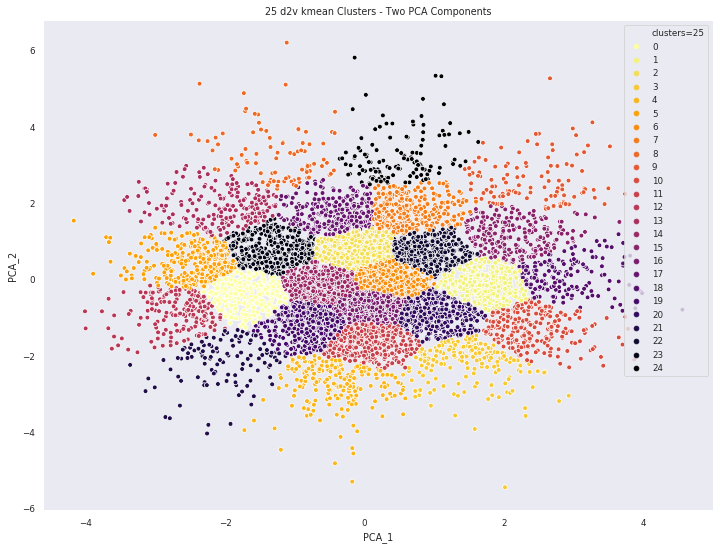


Avg Obs per cluster: 304.68

Number of observations per cluster:
16    589
6     542
14    541
2     516
19    418
11    390
20    379
1     370
22    359
23    357
0     351
7     336
dtype: int64
Time: 3.7597975730895996 seconds.



In [43]:
sns.set_context('paper')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

The two dimensional shape of the doc2vec vectors seems to have more symmetry than that of the TFIDF vectors.
Also another remark is the 5 ness of the clusters, they seem to be pentagonal.

Lets take a look at a cluster from one of the iterations and visualize the text.

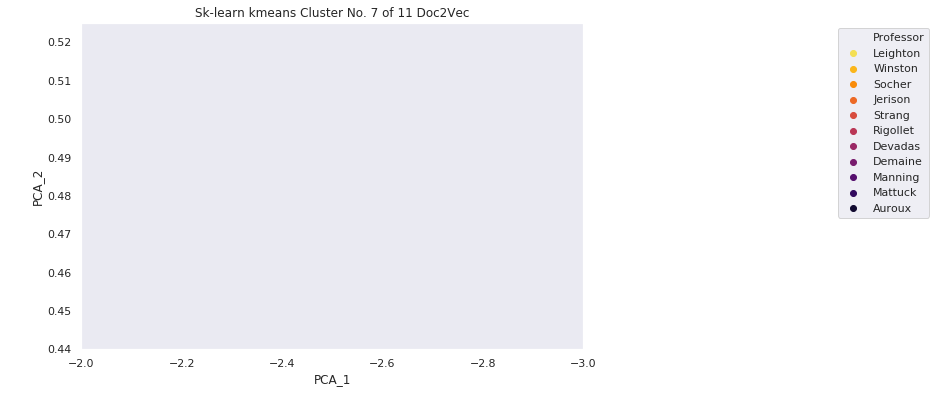

In [44]:
clusterd2v6 = pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6],
                palette='inferno_r')
for label, x, y in zip(clusterd2v6.original,clusterd2v6.PCA_1,clusterd2v6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(-2,-3)
plt.ylim(.44,.525)
plt.title('Sk-learn kmeans Cluster No. 7 of 11 Doc2Vec')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

So  far we have seen the K means algorithm create clusters of different sizes for both TF-IDF vectorization and Doc2Vec vecotrization.

The results of the silhouette scores were not very good. Many of them were close to zero for my desired clusters (10 or 11).
According to the documentation for sklearn silhouette score:
"Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

One observation to be made at this point is that the clusters seem to contain sentences that just have similar word use(see above).
How ever the clusters do not seem to line up directly with the similarity scores.
See below for an example.

In [45]:
#display sentences from referenced lecture
d2v_sim['cluster11'] = pca_d2vclusters['clusters=11']
sentence = 'p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.'
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','cluster11']].sort_values(by=[sentence],ascending=False)[:5]

p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.  \
6061                                           1.000000                                     
310                                            0.609259                                     
114                                            0.523888                                     
2441                                           0.522848                                     
6642                                           0.522624                                     

                                      Original_Sentence Professor  Subject  \
6061  p statement girl g reject boy b girl g suitor ...  Leighton  CS Math   
310   so alex prefer bobby joe bobby joe prefer robi...  Leighton  CS Math   
114    happen dave huffman committee say ad hoc thes...   Winston       AI   
2441       there be rogue couple m. b g rogue couple m.  Leighton  CS Math   
6642       so girl g bad m tma be mate m let b mate tma  Leighton  CS Math   

                filenames  cluster11  
6061  leighton7graphmatch          3  
310   leighton7graphmatch          2  
114            winstonai7          5  
2441  leighton7graphmatch          3  
6642  leighton7graphmatch          2

The next step is to define the model and examine each cluster

In order to proceed, we must chose a vectorization method, a clustering method and in our case, number of clusters.
So far the Doc2Vec seems to be doing a better job in terms of vectorization.  When comparing the TFIDF and D2V scatter shapes after PCA to two components, the Doc2Vec has better geometry.  For clustering, the K means algorithm is one of the only algorithms that is viable for this dataset, as it lets me define n_clusters and it is scalable. Other clustering algorithms, resulted in errors as the algorithms consistently determine that one cluster is optimal.
So for now, I have chosen Doc2Vec for vectorization and KMeans clustering for the clustering algorithm. Let's run the KMeans algorithm on the full vectors instead of the PCA version to determine how many clusters we want to define.

### Determine optimal number of clusters

In [46]:
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [47]:
#this loop iterates over a range of 10 to 46, in order to collect scores from each cluster
nclusts =[]
sscores = [] 
avgobs = []
obsstd = []
d2v_full = range(10,46,2)
for i in d2v_full:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(vecs)    
    nclusts.append(i)
    sscores.append(silhouette_score(vecs, d2v_clusters, metric='cosine'))
    avgobs.append(pd.value_counts(d2v_clusters).mean())
    obsstd.append(pd.value_counts(d2v_clusters).std())
    print('N. Clusters: {}, done!'.format(i))

N. Clusters: 10, done!
N. Clusters: 12, done!
N. Clusters: 14, done!
N. Clusters: 16, done!
N. Clusters: 18, done!
N. Clusters: 20, done!
N. Clusters: 22, done!
N. Clusters: 24, done!
N. Clusters: 26, done!
N. Clusters: 28, done!
N. Clusters: 30, done!
N. Clusters: 32, done!
N. Clusters: 34, done!
N. Clusters: 36, done!
N. Clusters: 38, done!
N. Clusters: 40, done!
N. Clusters: 42, done!
N. Clusters: 44, done!


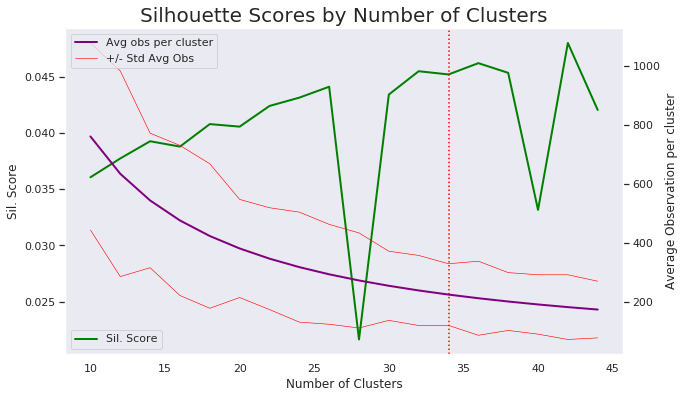

In [48]:
#Visualize Results
obsstd1 = [ i+j for i,j in zip(avgobs,obsstd)]
stdneg = [ i-j for i,j in zip(avgobs,obsstd)]

sns.set_context('notebook')
fig, ax = fig, ax = plt.subplots(figsize=(10,6))

ax2 = ax.twinx()
ax = sns.lineplot(nclusts, sscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(nclusts, avgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(nclusts,obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(nclusts,stdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=34,color='r',linestyle='dotted')
ax.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.show()

In this chart we can see that the silhouette scores are pretty volitile (and low). The objective is to pick a cluster number with a relatively high silhouette score and a relatively even distribution of observations per cluster.  The chart seems to indicate that cluster numbers of ~25-40 appear to bethe best selection, and the red bands straddling the purple line indicates lower variance which suggests the distribution of observations per cluster is evening out.

At this point, I have decided to disregard the pre determined number of clusters (10+11) and elect to use 34 clusters. I chose 34 because of the score.

Lets reduce the dimensionality using both PCA and this time also t-SNE, (as it is said be good for visualization of texts.)

" t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

#### 34 Clusters reduced to two PCA components
    1. Reduce dimensionality to two components
    2. Cluster the data in 34 clusters using KMeans clustering
    3. Plot the results

Number of Clusters: 34




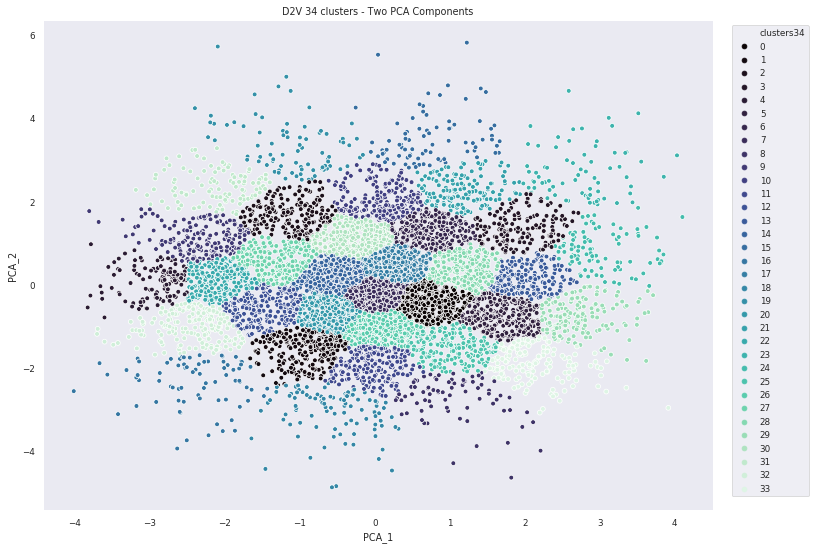

In [49]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels
pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]
pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Y34)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

#### 34 Clusters reduced to two PCA components
    1. Cluster the data in 34 clusters using KMeans clustering
    2. Reduce dimensionality to two components 
    3. Plot the results

Number of Clusters: 34




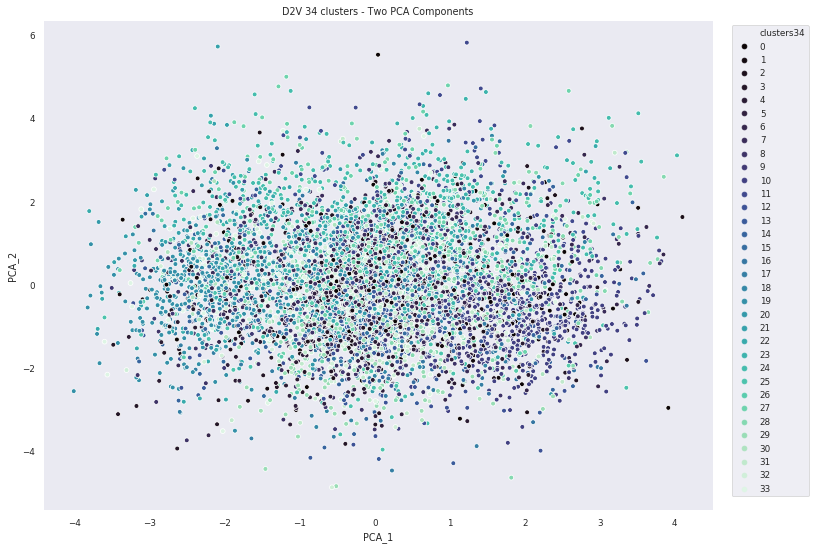

In [50]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]

d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs) 
#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels

pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
   
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

We can see that when we reduce the original data to two clusters and then cluster the results, each verticle line of points shares multiple cluster groups, where as clustering the data first and then reducing the dimensionality leads to more consist cluster assignments for a given line.

Lets do the same with t-SNE

#### 34 clusters reduce with t-SNE to two components
    1. Cluster the data into 34 clusters with KMeans algorithm
    2. Reduce dimensionality to two components
    3. Plot the results

Number of Clusters: 24

Silhouette Score: -0.01373656656271133




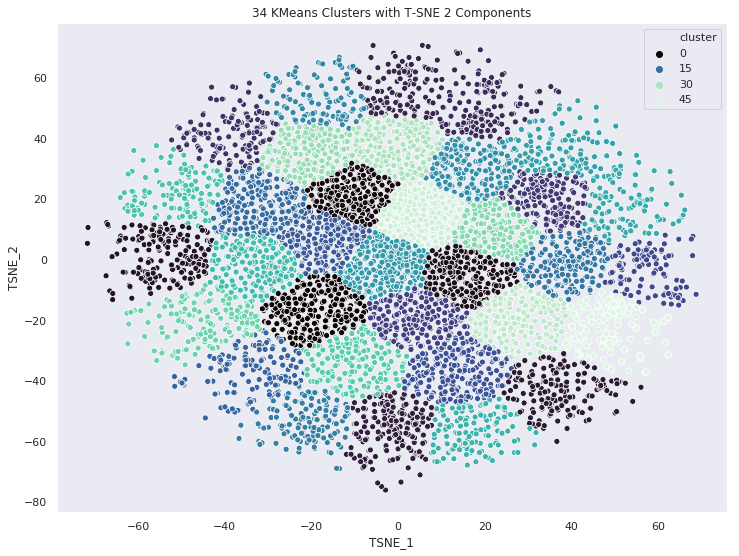

Time: 124.03765749931335 seconds.



In [51]:
t1 = time.time()
tsne2 = TSNE(n_components=2, random_state=43, metric='cosine')
tsne2_d2v = pd.DataFrame()
tsne2_d2v['original'] = X_train
tsne2_d2v['Professor'] = y_train[:,0]
tsne2_d2v['Subject'] = y_train[:,1]
tsne2_d2v['filename'] = y_train[:,2]

sns.set_context('paper')

#Reduce dimentionality
Yt = tsne2.fit_transform(vecs)
#Cluster the reduced data
d2v_clusters2 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Yt)    
print('Number of Clusters: 24')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters2, metric='cosine'))
print('\n')


tsne2_d2v['TSNE_1'] = Yt[:,0]
tsne2_d2v['TSNE_2'] = Yt[:,1]
tsne2_d2v['cluster'] = d2v_clusters2

#plot the results
plt.figure(figsize=(12,9))
sns.set_context('notebook')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne2_d2v, palette='mako')
plt.legend(loc='upper right')
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()

t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))



Number of Clusters: 34

Silhouette Score: 0.04523654410175289




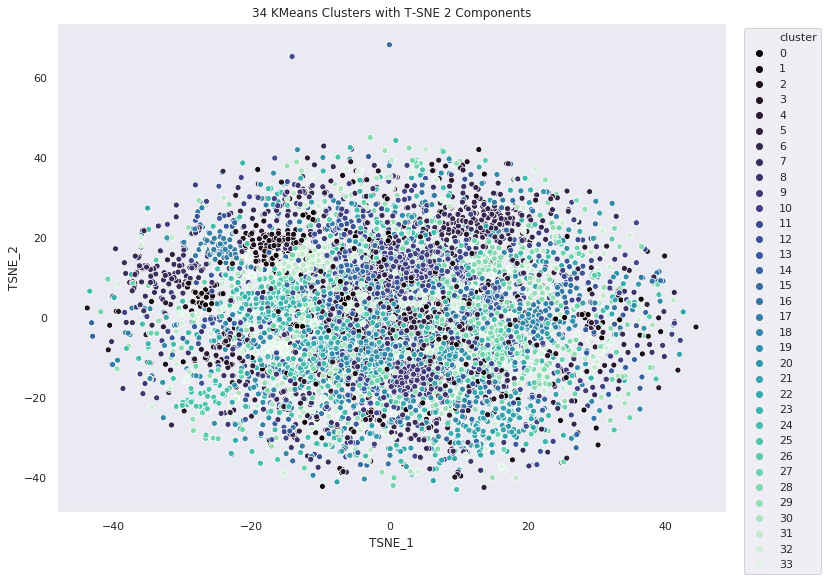


Avg Obs per cluster: 224.02941176470588

Number of observations per cluster:
19    499
10    499
24    402
5     367
27    358
6     315
28    279
32    269
13    269
21    268
8     255
11    254
dtype: int64
Time: 154.19616222381592 seconds.



In [52]:
#instantiate TSNE, set up a dataframe for graphing
tsne = TSNE(n_components=2,random_state=43)
tsne_d2v = pd.DataFrame()
tsne_d2v['original'] = X_train
tsne_d2v['Professor'] = y_train[:,0]
tsne_d2v['Subject'] = y_train[:,1]
tsne_d2v['filename'] = y_train[:,2]

t1 = time.time()
d2v_clusters = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters, metric='cosine'))
print('\n')

Yt = tsne.fit_transform(vecs)
tsne_d2v['TSNE_1'] = Yt[:,0]
tsne_d2v['TSNE_2'] = Yt[:,1]
tsne_d2v['cluster'] = d2v_clusters
plt.figure(figsize=(12,9))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne_d2v, palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()
print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
print('Number of observations per cluster:')
print(pd.value_counts(d2v_clusters)[:12])    
t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))

In [53]:
#interesting shape!

#### Select a few clusters and look at sentences

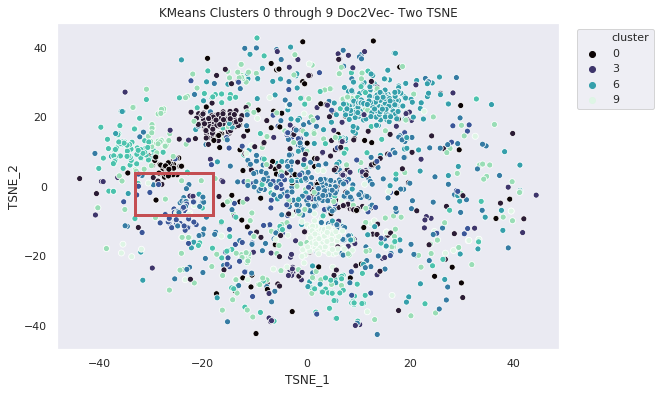

In [54]:
ts = tsne_d2v.copy()
keeps = [ i for i in ts.index if ts.cluster[i] >= 1 and ts.cluster[i] <= 9]
ts = ts.iloc[keeps]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='cluster', 
                data=ts,
                palette='mako')
rect = patches.Rectangle((-33,-8),15,12,linewidth=3,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
#for label, x, y in zip(tsned2v33.original,tsned2v33.TSNE_1,tsned2v33.TSNE_2):
    #plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

#plt.xlim(-2,2)
#plt.ylim(-10,10)

plt.title('KMeans Clusters 0 through 9 Doc2Vec- Two TSNE')
plt.legend(bbox_to_anchor=[1.2,1],loc='upper right')
plt.show() 

plt.show()

In [55]:
#look at the intersection of the three clusters

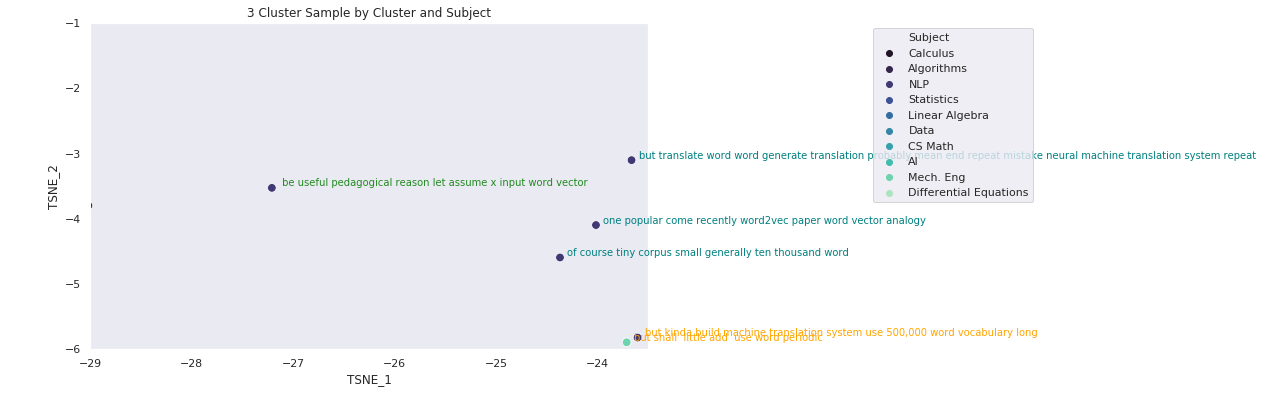

In [78]:
tsned2v33 = tsne_d2v[tsne_d2v['cluster'] <= 4]
plt.figure(figsize=(10,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='Subject', 
                data=ts,
                palette='mako', s=75)
for i, clust in enumerate(tsned2v33.cluster):
    colors=['r','b','g','purple','orange','teal','c','m','forestgreen','orangered','limegreen']
    ltsned2v33 = ts[ts.cluster == i]
    for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
        plt.annotate(label, xy=(x, y), xytext=(7, 2), color=colors[i], textcoords='offset points',fontsize=10)

plt.xlim(-29,-23.5)
plt.ylim(-6,-1)
plt.title('3 Cluster Sample by Cluster and Subject')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

### Intracluster similarity of sentences
The subjects of each cluster aren't clear yet. We need to look at each cluster and examine how similar it's sentences are to each other. To do this we will use the cosine similarity matrix to calculate the intracluster similarity of each sentence Then we will visually inspect the results to determine any patterns, topics etc.

In [57]:
#We need to add the cluster numbers to the vecs dataframe
subsprofs = pd.DataFrame(y_train)
subsprofs['cluster_no'] = d2v_clusters
subsprofs[3] = X_train
vecs['cluster_no'] = d2v_clusters
for_sims = pd.DataFrame(X_train)
for_sims['cluster_no'] = d2v_clusters

In [58]:
# this function iterates over clusters and calculates the average cosine similarity score of sentences
#For each cluster, a dictionary stores cluster level information as keys and returns a data frame
#with the 'num_sents'(int) most related sentences as rows and the lecture source and intracluster mean similarity
#as columns
n_clusters = 34
def get_similarities(num_sents):    
    sim_sents = OrderedDict()
    lects = OrderedDict()
    mean_sims = {}
    
    # iterate over clusters
    for i in range(n_clusters):
        tmpdf = vecs[vecs.cluster_no == i]
        tmpdf = tmpdf.drop(['cluster_no'],1)
        tmp1 = for_sims[for_sims.cluster_no == i ]
        tmp1 = tmp1.drop(['cluster_no'],1)
        # calculate cosine similarity with Sklearn's cosine_similarity method and store in dataframe
        df_sim = pd.DataFrame(cosine_similarity(tmpdf), index=range(len(tmp1)), columns=tmp1)          
        # insert a column with the average similarity score of each row in the similarity matrix
        df_sim.insert(0, 'mean_similarity', df_sim.mean(axis=1)) 
        df_sim.insert(0, 'lecture', subsprofs[subsprofs.cluster_no == i][2].reset_index(drop=True))
        df_sim.insert(0, 'original_sentence', tmp1.reset_index(drop=True))
        # calculate the cluster's global average similarity score
        mean_similarity = df_sim.mean_similarity.mean()        
        # store the cluster's global average similarity score in a dictionary
        mean_sims['cluster {}'.format(i)] = mean_similarity
        mean_sims['cluster {}'.format(i)] = mean_similarity
        #the DataFrame will be the dictionary value
        top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]
        # store the most similar sentence and the average similarity score of clusters
        sim_sents['cluster_{} | {} sentences | mean similarity: {}'.format(
            i, df_sim.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

In [59]:
#call the function for 10 sentences per cluster
ten_sents, mean_sims = get_similarities(10)

In [60]:
#For each cluster, examine the top 10 most similar sentences in each cluster, along with the source
for i in ten_sents:
    vals = ten_sents[i]
    print('\n{}'.format(i))
    print('\nOriginal Sentence\n\n{}\n\nLecture\n\n{}\\nnMean_sim\n\n{}'.format(
        vals.original_sentence,vals.lecture,vals.mean_similarity))


cluster_0 | 124 sentences | mean similarity: 0.3035902006087563

Original Sentence

54    so basically intuitively  rephrase question an...
60    and basically main takeaway message blue layer...
91    so basically baseline go to begin chen manning...
40    and basically term basically wanna maximize lo...
10     basically horizontally fall ladder cover need...
76     basically bunch input say castle north beach ...
36    the sentence basically hidden state hope captu...
46    basically kind model mechanism compute represe...
47    basically question class important know f1 met...
83    and apply newton 's method  go symbolic equati...
Name: original_sentence, dtype: object

Lecture

54       sochernlp16
60       manningnlp8
91       manningnlp8
40        sochernlp3
10     demainedata15
76       sochernlp16
36       sochernlp16
46       sochernlp16
47       manningnlp8
83    devadasalgos12
Name: lecture, dtype: object\nnMean_sim

54    0.441536
60    0.396178
91    0.393673
40    0.38

## Assessing the clusters
 - After calculating the intercluster similarities, some real patterns have started to emerge.
     - The clusters appear to exhibit the same characteristics as before (ie identifying the same word use in different sentences) however, with 34 clusters (we looked at 10, 11 before) some clusters seem to have more relavent similar sentences, even topics. For example, the topic of cluster 33 is clearly probability, not only do the sentences suggest it, but the sentence sources suggest it could be the 'topic' of the cluster. (other sentences pertaining to probability also show up in other clusters) Other clusters on the other hand do not share this 'topic' characteristic.  For instance cluster 25 is a eclectically sourced collection of sentences starting with the word 'but'.
     
   - Note that this analysis was true of the first iteration of the notebook. The clusters do not have the same assigned sentences if ran again. However, after running the Kmeans on the data multiple times, the same sentences seems to get clustered together, just in a different cluster assignments


#### Examining Word Frequencies
     - By extracting the word frequencies and subject/professor/lecture density of each cluster, maybe we can draw new insight.

In [61]:
#this function removes any 's in the text, tokenizes and stems the word
def clean_lite (text):
    re.sub(" 's",'',text)
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if len(word) > 3]
    words = [word for word in words if word not in default_stopwords]
    #words = [stemmer.stem(word) for word in words]
    return words    

In [62]:
#add the sentences to our previous dataframe
subsprofs[3] = X_train

In [63]:
subsprofs.head()

0           1                2  cluster_no  \
0  Rigollet  Statistics   rigolletstats3          17   
1   Devadas  Algorithms    devadasalgos4          30   
2   Devadas  Algorithms   devadasalgos10          20   
3   Devadas  Algorithms    devadasalgos1          16   
4  Rigollet  Statistics  rigolletstats13          31   

                                                   3  
0  and non parametric estimation typically actual...  
1  now discard node n heap simply decrement heap ...  
2  so probabilistic argument assume hash function...  
3  then guess 2d peak great equal b great equal d...  
4  then  say  want y plus bx  go add noise epsilo...

In [64]:
#iterate over each cluster, 
#convert all sentences in each cluster to one str
#tokenize, stem words, count frequencies of words, subjects, professors and lecture id
for i in sorted(subsprofs.cluster_no.unique()):
    #iterate by cluster
    cluster_df = subsprofs[subsprofs.cluster_no == i].reset_index(drop=True)
    #Make one large string
    cluster_str = ' '.join([ ' '.join([i]) for i in cluster_df[3]]) 
    #run lite cleaner
    cluster_str = clean_lite(cluster_str)
    
    fdist = nltk.FreqDist(cluster_str)
    freq_words = list(Counter(fdist).most_common(5))
    profs = Counter(dict(cluster_df[0].value_counts())).most_common(5)
    subs = Counter(dict(cluster_df[1].value_counts())).most_common(5)
    lects = Counter(dict(cluster_df[2].value_counts())).most_common(5)
    print('Cluster Number: {}, Sentences: {}\n Words and Counts:{}\n Professors: {}\n Subjects:{}\n Lectures: {}\n'.format(\
        i,cluster_df.shape[0],freq_words,profs,subs, lects))

Cluster Number: 0, Sentences: 124
 Words and Counts:[('basically', 120), ('word', 21), ('compute', 14), ('time', 14), ('model', 13)]
 Professors: [('Socher', 50), ('Rigollet', 26), ('Manning', 19), ('Demaine', 11), ('Devadas', 9)]
 Subjects:[('NLP', 69), ('Statistics', 26), ('Data', 11), ('Algorithms', 9), ('Calculus', 4)]
 Lectures: [('sochernlp16', 18), ('manningnlp8', 18), ('sochernlp3', 16), ('sochernlp13', 10), ('rigolletstats11', 7)]

Cluster Number: 1, Sentences: 135
 Words and Counts:[('need', 147), ('know', 17), ('thing', 13), ('time', 12), ('order', 12)]
 Professors: [('Rigollet', 32), ('Demaine', 31), ('Devadas', 17), ('Jerison', 11), ('Winston', 11)]
 Subjects:[('Statistics', 32), ('Data', 31), ('Algorithms', 17), ('Calculus', 13), ('AI', 11)]
 Lectures: [('demainedata11', 7), ('rigolletstats1', 6), ('demainedata15', 5), ('demainedata14', 5), ('rigolletstats5', 5)]

Cluster Number: 2, Sentences: 218
 Words and Counts:[('know', 255), ('want', 22), ('right', 22), ('actually',

Cluster Number: 19, Sentences: 499
 Words and Counts:[('word', 50), ('equal', 43), ('vector', 42), ('minus', 41), ('theta', 32)]
 Professors: [('Rigollet', 77), ('Leighton', 76), ('Socher', 65), ('Winston', 43), ('Jerison', 41)]
 Subjects:[('NLP', 106), ('Statistics', 77), ('CS Math', 76), ('Calculus', 59), ('AI', 43)]
 Lectures: [('sochernlp16', 22), ('manningnlp10', 19), ('sochernlp13', 17), ('rigolletstats8', 16), ('sochernlp3', 14)]

Cluster Number: 20, Sentences: 138
 Words and Counts:[('good', 154), ('model', 11), ('think', 10), ('actually', 10), ('word', 10)]
 Professors: [('Leighton', 31), ('Socher', 21), ('Strang', 16), ('Rigollet', 15), ('Mattuck', 15)]
 Subjects:[('NLP', 32), ('CS Math', 31), ('Statistics', 15), ('Differential Equations', 15), ('Linear Algebra', 10)]
 Lectures: [('leighton7graphmatch', 9), ('sochernlp3', 8), ('sochernlp13', 7), ('leighton20indcs', 5), ('manningnlp2', 5)]

Cluster Number: 21, Sentences: 268
 Words and Counts:[('minus', 190), ('plus', 113), ('

After examing the occurance frequencies of each tokens and their identifying labels, we see some support for our hypothesis. For instance the word probability occurs 184 times, while the next common word is 'equal' with 21 counts. In fact 19 of the 34 clusters have a word that is present at least more than 4 four times than the second most frquently occuring word, in some clusters that rate is almost 10.
 - Clusters with dominant words:
     - 1,3,5,6,7,8,10,14,15,16,19,20,21,24,26,28,30,32,33
 - Clusters with out dominant words include those not listed above. The most common words occur at a rate less than 2 twice the second word, and do not really seem to be related to any particular topic. The word 'actually' shows up alot.
 -  A last observation is the similarities between clusters 30 and 32 where the 2 most common words are 'need' and 'know' - and - 'know' and 'want'. As in 'i need to know x, once i have x i want to y'
 
While this analysis shed some light on new patterns not seen before, we can use another technique called NonNegative Matrix Factorization. We will apply a minMax scaler to that data move all the data points positive between 0 and 1. then for each cluster we will apply the fit and see how the sentences are groups. This is a common way of finding subtopics with clusters.

In [65]:
#define a function to extract subtopics

def nmf_topics(vec_matrix, num_sents):
    sim_sents = OrderedDict()
    
    for i in range(n_clusters):
        tmp1 = subsprofs[subsprofs.cluster_no == i]
        temp_matrix = vecs
        temp_matrix['cluster_no'] = subsprofs.cluster_no
        temp_matrix = temp_matrix[temp_matrix.cluster_no == i]
        temp_matrix = minmax_scale(temp_matrix.drop(['cluster_no'],1))
        n_comps = int(np.ceil(temp_matrix.shape[0] * .01)) #100 sentences per component
        #Instaniate a NMF instance 

        nmf = NMF(alpha=0.35, 
                  init='nndsvdar', # how starting value are calculated
                  l1_ratio=0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_comps, 
                  random_state=43, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=1) # amount of output to give while iterating
        components = nmf.fit_transform(temp_matrix)
        df_components = pd.DataFrame(components, index=tmp1[[2,3]])
        df_components.insert(0, 'sentence',tmp1[3])
        df_components.insert(0, 'lecture',tmp1[2].reset_index(drop=True))
                                    
        for col in df_components.columns[2:]:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents
        
        print('Cluster {}: {} observations , {} components'.format(i, temp_matrix.shape[0],n_comps))
    
    return sim_sents



In [66]:
#Call the function
cluster_topics = nmf_topics(vecs, 10)

violation: 1.0
violation: 0.5242461768624492
violation: 0.4310853193856406
violation: 0.3609227364097124
violation: 0.3030402792538827
violation: 0.26145336743102
violation: 0.22717593996635496
violation: 0.20194476483748275
violation: 0.1815425987369396
violation: 0.16553721040133929
violation: 0.1524464459198897
violation: 0.14169768881292505
violation: 0.13233943817213115
violation: 0.12360189233720924
violation: 0.11547897916620198
violation: 0.10800731748213205
violation: 0.10113243038896014
violation: 0.09498549670111713
violation: 0.08939234494859337
violation: 0.08414755864313617
violation: 0.07940609895267227
violation: 0.07502300436897465
violation: 0.07092048227701261
violation: 0.06710668765072628
violation: 0.06355153180513914
violation: 0.06017215492593197
violation: 0.0570464718281596
violation: 0.05423116066076714
violation: 0.05174757312619319
violation: 0.04947386150948152
violation: 0.04742929651589717
violation: 0.045604201305218986
violation: 0.04394226871366825
vi

violation: 0.005219677981627978
violation: 0.005206949038247906
violation: 0.00519662304926063
violation: 0.0051917298369951025
violation: 0.00518256727767643
violation: 0.005174300965871727
violation: 0.005166711169927317
violation: 0.005159629611997896
violation: 0.005152984111821898
violation: 0.0051466464531157155
violation: 0.005140520557347231
violation: 0.005134554821445415
violation: 0.0051287119578065695
violation: 0.0051229650934578935
violation: 0.005117294801870463
violation: 0.0051116869395210415
violation: 0.0051061311048535675
violation: 0.005100619553525169
violation: 0.005095146439038782
violation: 0.005089707280643378
violation: 0.005084298589856921
violation: 0.0050789176067863534
violation: 0.0050735945167210235
violation: 0.005068301197432922
violation: 0.005063030735535233
violation: 0.005057781726187771
violation: 0.0050525529666893285
violation: 0.005047343415362733
violation: 0.0050421521595716955
violation: 0.005036978391833807
violation: 0.005031821390835213


violation: 0.011143767556223436
violation: 0.011097494383132706
violation: 0.011051386794704215
violation: 0.011005444092274492
violation: 0.010959741319271412
violation: 0.010914232236952126
violation: 0.010868883466664363
violation: 0.010823694358628774
violation: 0.01077866426798307
violation: 0.010733792555625699
violation: 0.010689078588912966
violation: 0.01064452174225526
violation: 0.010600121397597317
violation: 0.010555876944846025
violation: 0.01051178778219959
violation: 0.010467853316404657
violation: 0.010424072963045917
violation: 0.010380446146568138
violation: 0.01033697230059415
violation: 0.010293650867760847
violation: 0.010250481299913317
violation: 0.01020746305801433
violation: 0.010164595612188618
violation: 0.010121878441562777
violation: 0.010079311034246564
violation: 0.01003689288723706
violation: 0.009994623506215482
violation: 0.009952502405503464
violation: 0.009910529107814483
violation: 0.009868703144091233
violation: 0.00982702405346083
violation: 0.00

violation: 0.007055428468967509
violation: 0.007022630447736757
violation: 0.006990008907921179
violation: 0.006957527167259175
violation: 0.006925185366872484
violation: 0.006893169019003052
violation: 0.006861358671891693
violation: 0.006829840480951487
violation: 0.0067985042229905136
violation: 0.00676745077740574
violation: 0.0067366506823943635
violation: 0.006706042999383104
violation: 0.006675567608992512
violation: 0.006645224573943168
violation: 0.006615013935883757
violation: 0.006584935716038116
violation: 0.0065550086326197484
violation: 0.006525219981195159
violation: 0.006495597130448646
violation: 0.00646610629585916
violation: 0.0064367474059003294
violation: 0.006407520371657303
violation: 0.006378425087370606
violation: 0.006349493531384949
violation: 0.0063215521979055975
violation: 0.006295120631899153
violation: 0.0062688775874590675
violation: 0.006242394840944229
violation: 0.006215822149763967
violation: 0.006189242093667402
violation: 0.006162722985903607
viol

violation: 1.0
violation: 0.4777411712583368
violation: 0.3760568162678176
violation: 0.31572235395779213
violation: 0.272325769334518
violation: 0.23868614557270354
violation: 0.2132852904743993
violation: 0.1931071957347894
violation: 0.17773166525648823
violation: 0.1647120941845344
violation: 0.1541803836361195
violation: 0.1463326713716739
violation: 0.13929330290737374
violation: 0.13327228596608306
violation: 0.12793784051938922
violation: 0.12294465153990361
violation: 0.11822572768369309
violation: 0.11374102647765676
violation: 0.10963943336335183
violation: 0.10557835021847764
violation: 0.10181887668435502
violation: 0.09834825655245245
violation: 0.09501040251070193
violation: 0.09175997986521164
violation: 0.0886570084003075
violation: 0.08569082498391675
violation: 0.08284937236027441
violation: 0.08013121186915322
violation: 0.07765929755267086
violation: 0.07543268971673721
violation: 0.07337150340507377
violation: 0.0713909319950968
violation: 0.06958574983238627
viol

violation: 0.011275234099842246
violation: 0.011252437585040577
violation: 0.011229660579702233
violation: 0.011206903505271737
violation: 0.011184166770548188
violation: 0.011161450772359147
violation: 0.011138755895828965
violation: 0.011116082514594717
violation: 0.011093430991280889
violation: 0.011070801677809548
violation: 0.01104819491562774
violation: 0.011025611036133962
violation: 0.011003050360875472
violation: 0.010980513201916947
violation: 0.010957999862037065
violation: 0.010935510635108604
violation: 0.010913045806321492
violation: 0.010890605652354632
violation: 0.010868190441802528
violation: 0.010845800435364877
violation: 0.010823435885914412
violation: 0.01080109703890187
violation: 0.01077878413265475
violation: 0.010756497398328674
violation: 0.010734237060334497
violation: 0.010712003336500117
violation: 0.010689796438186818
violation: 0.01066761657054955
violation: 0.010645463932717878
violation: 0.010623338717979871
violation: 0.010601241113888564
violation: 0

violation: 0.0055707407204351874
violation: 0.005557299281017639
violation: 0.005543939554544404
violation: 0.0055306460591324595
violation: 0.005517412662253198
violation: 0.005504280013234581
violation: 0.005491218135998997
violation: 0.005478212068840033
violation: 0.0054652623496137705
violation: 0.005452370015644436
violation: 0.005439529125640745
violation: 0.0054267484308244745
violation: 0.005414029112106806
violation: 0.005401404727162766
violation: 0.005388838498854053
violation: 0.005376317591840359
violation: 0.005363841262700054
violation: 0.005351409068862052
violation: 0.005339020575887665
violation: 0.005326684026110865
violation: 0.00531439956078953
violation: 0.005302185307346998
violation: 0.005290025113467417
violation: 0.005277906240815336
violation: 0.005265828299561874
violation: 0.005253802551800125
violation: 0.005241838502512639
violation: 0.0052298767442600005
violation: 0.0052162654588530115
violation: 0.005203118025092643
violation: 0.005190136429813927
vio

violation: 0.0074515508113518186
violation: 0.007416995950691947
violation: 0.007382605608835168
violation: 0.007348403131909899
violation: 0.007314371830372278
violation: 0.007280492520004655
violation: 0.0072467781090878305
violation: 0.007213217118447564
violation: 0.007179820587095845
violation: 0.007146573942656775
violation: 0.007113478306653025
violation: 0.007080531280706634
violation: 0.007047727514427062
violation: 0.007015066132471565
violation: 0.0069825462816482334
violation: 0.0069501894072910055
violation: 0.006918012991939473
violation: 0.006885981429747292
violation: 0.006854086786622189
violation: 0.00682232832948696
violation: 0.00679070533921845
violation: 0.006759220741409099
violation: 0.006727874710909236
violation: 0.006696665867345004
violation: 0.006665589568053637
violation: 0.006634650065926012
violation: 0.00660384873419795
violation: 0.006573182751061204
violation: 0.006542660792879198
violation: 0.006512274021251132
violation: 0.00648201520812158
violatio

violation: 0.005440877406995798
violation: 0.005423027839644825
violation: 0.005405456648762072
violation: 0.005388149493995209
violation: 0.005371085188136087
violation: 0.005354240856372718
violation: 0.005337594872390774
violation: 0.0053211282458815465
violation: 0.0053048250371771685
violation: 0.005288672229291278
violation: 0.005272659346511669
violation: 0.00525677799530976
violation: 0.005241021422834635
violation: 0.005225384136054104
violation: 0.005209861594269974
violation: 0.005194449971522348
violation: 0.005179145978614307
violation: 0.005163946732714329
violation: 0.005148849663010793
violation: 0.005133852443138341
violation: 0.005118968551612291
violation: 0.005104210424854843
violation: 0.005089543384755091
violation: 0.005074965979905936
violation: 0.005060476823186387
violation: 0.005046074586746652
violation: 0.005031757997508386
violation: 0.005017525832977099
violation: 0.005003376917565146
violation: 0.00498931011913444
violation: 0.004975324346029144
violatio

violation: 0.005201461361493585
violation: 0.005182701477411216
violation: 0.005164007183945784
violation: 0.00514537806738372
violation: 0.005126813720024027
violation: 0.005108313740079867
violation: 0.00508987773164066
violation: 0.005071505304574783
violation: 0.005053196074607879
violation: 0.005034949663219929
violation: 0.0050167717456746745
violation: 0.004998659803081624
violation: 0.00498060945558897
violation: 0.004962620343441266
violation: 0.004944692113689451
violation: 0.004926824419978703
violation: 0.004909016922464499
violation: 0.0048912692877243254
violation: 0.004873581188575276
violation: 0.004855952303994266
violation: 0.0048383823190255495
violation: 0.004820870924670114
violation: 0.004803417817726496
violation: 0.004786022700772537
violation: 0.0047686852820189194
violation: 0.004751405275172708
violation: 0.004734182399412029
violation: 0.004717016379230523
violation: 0.004699906944394181
violation: 0.0046828538297316235
violation: 0.004665856775219321
violat

violation: 0.009047317690951373
violation: 0.009016785718446793
violation: 0.008986963630879585
violation: 0.008957713439130963
violation: 0.008928926428710555
violation: 0.008900518664322423
violation: 0.008872425797080903
violation: 0.00884464829164585
violation: 0.008817112077227766
violation: 0.008789799415091481
violation: 0.008762829630809595
violation: 0.008736100157715464
violation: 0.008709508920407717
violation: 0.008683045013587905
violation: 0.0086567897826704
violation: 0.008630672359403787
violation: 0.008604657021293313
violation: 0.008578782923535571
violation: 0.008553069660350946
violation: 0.008527443958532194
violation: 0.008501903335756206
violation: 0.00847667951403149
violation: 0.00845158643134929
violation: 0.008426569204414055
violation: 0.008401626757685543
violation: 0.008376758192284518
violation: 0.00835196275424932
violation: 0.008327239809209332
violation: 0.00830258882153444
violation: 0.008278009337174668
violation: 0.00825351076441767
violation: 0.008

violation: 0.011940087157949742
violation: 0.011894081272982684
violation: 0.01184834884985751
violation: 0.011802828226716598
violation: 0.011757473050223143
violation: 0.011712215428683009
violation: 0.011667077743740532
violation: 0.011621941371256553
violation: 0.011576990028822886
violation: 0.011532084053109943
violation: 0.01148716179945126
violation: 0.011442203503125076
violation: 0.011397210485677328
violation: 0.01135217878504468
violation: 0.011307174547788273
violation: 0.011261985787122718
violation: 0.01121688834157864
violation: 0.011173224169333229
violation: 0.011129623491040772
violation: 0.011088090842970893
violation: 0.011048296577649615
violation: 0.011008704419015504
violation: 0.010968806419001883
violation: 0.01093069327880922
violation: 0.010893541548015412
violation: 0.01085628959070578
violation: 0.010819142906416062
violation: 0.010783576472925615
violation: 0.010744694850280305
violation: 0.0107068243407869
violation: 0.010668860932667609
violation: 0.010

violation: 0.004591014853774463
violation: 0.004574565666108326
violation: 0.004558142587770576
violation: 0.004541746795883934
violation: 0.00452537928861774
violation: 0.004509040931815611
violation: 0.004492732490529473
violation: 0.004476454650539299
violation: 0.004460208033529888
violation: 0.004444519579202412
violation: 0.00443087629779882
violation: 0.0044174509345703055
violation: 0.004403783986419385
violation: 0.004390070513706707
violation: 0.0043763759264224995
violation: 0.004362714758181214
violation: 0.004349089780573472
violation: 0.004335518606493995
violation: 0.004321992318617489
violation: 0.004308504458748288
violation: 0.0042950473388698686
violation: 0.00428162019628574
violation: 0.0042682184542554
violation: 0.004254835237925232
violation: 0.004241470151731336
violation: 0.004228123022048647
violation: 0.004214793829598474
violation: 0.004201482663863937
violation: 0.004188189691830567
violation: 0.004174915136265308
violation: 0.004161659259927142
violation:

violation: 0.005905423310554872
violation: 0.005890213032778628
violation: 0.00587504747623072
violation: 0.005859926432615811
violation: 0.005844849692551624
violation: 0.005829817045666337
violation: 0.0058148282806342
violation: 0.005799883185544721
violation: 0.005784981547523138
violation: 0.0057701231532340126
violation: 0.005755307788847942
violation: 0.005740535240168225
violation: 0.005725805292743606
violation: 0.0057111177320455665
violation: 0.005696472343491997
violation: 0.005681868912721177
violation: 0.00566730722545229
violation: 0.005652787067968733
violation: 0.005638308226891935
violation: 0.005623870489495834
violation: 0.0056094736437006095
violation: 0.005595117478329965
violation: 0.005580801783036705
violation: 0.005566526348482972
violation: 0.00555229096651789
violation: 0.005538095430080058
violation: 0.005523939533410163
violation: 0.0055098230721106495
violation: 0.0054957458432358325
violation: 0.005481707645307076
violation: 0.005467708278403435
violatio

violation: 0.010239186412910198
violation: 0.010172669228189683
violation: 0.010106349374936392
violation: 0.010040324728666603
violation: 0.009974599999722087
violation: 0.009909124786482766
violation: 0.009843828750779113
violation: 0.009778720917324157
violation: 0.009713810801683001
violation: 0.00964910778012598
violation: 0.009584626496471895
violation: 0.00952040627200557
violation: 0.009456417823385571
violation: 0.009392698801029756
violation: 0.009329283634269093
violation: 0.009267627594586918
violation: 0.009207825259261315
violation: 0.009148151217976772
violation: 0.009088326448413621
violation: 0.009028598759308167
violation: 0.008969145146335037
violation: 0.008910040998542933
violation: 0.00885120117546563
violation: 0.00879268644477926
violation: 0.008734441297350702
violation: 0.008676524765056601
violation: 0.008618986039855935
violation: 0.008561814624264249
violation: 0.008505148006682043
violation: 0.008448928808889191
violation: 0.008393148947623478
violation: 0

violation: 0.00444798643574383
violation: 0.004431804201586474
violation: 0.00441567627460086
violation: 0.004406647117898262
violation: 0.0043963046479661766
violation: 0.004385146971471716
violation: 0.004374787530899514
violation: 0.004365075000628097
violation: 0.004355874054339573
violation: 0.004347075047117192
violation: 0.004338592986557686
violation: 0.004330363256296087
violation: 0.004322337016831576
violation: 0.004314477270110534
violation: 0.004306755786190414
violation: 0.00429915080584968
Cluster 14: 119 observations , 2 components
violation: 1.0
violation: 0.5225559951904151
violation: 0.41013832355135926
violation: 0.3428468056234311
violation: 0.29563228543345627
violation: 0.25868227044743114
violation: 0.23017881673918558
violation: 0.20715413690531312
violation: 0.1882656006156119
violation: 0.17212627700876826
violation: 0.15782641807110925
violation: 0.14559896708811404
violation: 0.13506179818309622
violation: 0.12582846789604987
violation: 0.11763641908228574


violation: 0.006267806483105558
violation: 0.006240787750801716
violation: 0.006213918292833469
violation: 0.0061871884535411766
violation: 0.006160590442684589
violation: 0.006134117946614235
violation: 0.0061077658249032675
violation: 0.006081529874142351
violation: 0.0060554066435710655
violation: 0.006029393290709285
violation: 0.006003487466970812
violation: 0.005977687226779205
violation: 0.005951990954872613
violation: 0.005926397307234144
violation: 0.005900905163467192
violation: 0.005875513587724979
violation: 0.005850221796618633
violation: 0.005825029132896514
violation: 0.00579993504340023
violation: 0.0057749390609742905
violation: 0.005750040789283756
violation: 0.005725239890134465
violation: 0.005700536072760053
violation: 0.005675929085231549
violation: 0.005651418706449942
violation: 0.005627004740350563
violation: 0.005602687010245396
violation: 0.005578465354514023
violation: 0.0055543396227798825
violation: 0.005530309672712896
violation: 0.00550637536734469
viola

violation: 0.008972036136693527
violation: 0.008919890078993077
violation: 0.008868044146250326
violation: 0.008816496582455143
violation: 0.008765245637461316
violation: 0.00871428956729994
violation: 0.008663626634480899
violation: 0.00861325510837979
violation: 0.008563173265563294
violation: 0.00851337938997281
violation: 0.008463878056788549
violation: 0.008414671694080446
violation: 0.00836574750917354
violation: 0.008317103830796422
violation: 0.008268738996116973
violation: 0.00822065135130429
violation: 0.0081728392512907
violation: 0.008125301060199876
violation: 0.008078035151304818
violation: 0.008031039907278858
violation: 0.007984313720165377
violation: 0.007937854991546395
violation: 0.007891662132664606
violation: 0.007845733564372008
violation: 0.007800067717323562
violation: 0.007754663031949146
violation: 0.0077200588826256645
violation: 0.007679333331540091
violation: 0.007639462426926554
violation: 0.0076011217671376665
violation: 0.0075639732323086566
violation: 0

violation: 0.07333490777699649
violation: 0.07102789893770002
violation: 0.06881615845918207
violation: 0.06682075971542775
violation: 0.06484501291132905
violation: 0.06299908568991136
violation: 0.06126090812758838
violation: 0.05967440068257726
violation: 0.058190916627656276
violation: 0.05677805751638228
violation: 0.05542535707796417
violation: 0.05423429538408514
violation: 0.05307738969588241
violation: 0.05202308185897536
violation: 0.051031597706571806
violation: 0.050066228258582764
violation: 0.04915198254597561
violation: 0.04827336387573092
violation: 0.04746750610632394
violation: 0.04671891858650431
violation: 0.04596060913628961
violation: 0.0452391985514795
violation: 0.04464264764146734
violation: 0.04404368905306414
violation: 0.04348536822046371
violation: 0.04295743305129535
violation: 0.042456421051942674
violation: 0.041995171724933125
violation: 0.04154320529518449
violation: 0.04110527740931538
violation: 0.04067593057312575
violation: 0.04025354898181862
viol

violation: 0.01121574486085311
violation: 0.011184828304222842
violation: 0.011153949253068026
violation: 0.011123107994884505
violation: 0.011092304811839149
violation: 0.01106153998090568
violation: 0.011030813774150357
violation: 0.011000126458821109
violation: 0.010969478297690812
violation: 0.010938869549103659
violation: 0.010908300467208965
violation: 0.01087777130207752
violation: 0.010847282299930242
violation: 0.0108168337031787
violation: 0.01078642575065038
violation: 0.010756058677698861
violation: 0.01072573271631827
violation: 0.01069544809530605
violation: 0.010665205040252488
violation: 0.010635003773814974
violation: 0.01060484451573001
violation: 0.01057472748282819
violation: 0.010544652889313742
violation: 0.010514620946729255
violation: 0.010484631863996842
violation: 0.010454685847674415
violation: 0.010424783101750013
violation: 0.010394923827968635
violation: 0.010365108225819217
violation: 0.010335336492455221
violation: 0.010305608822993296
violation: 0.01027

violation: 0.008576198382502422
violation: 0.008536881125969842
violation: 0.008497749482193808
violation: 0.008458896043172279
violation: 0.008421590468792364
violation: 0.008387861659883436
violation: 0.008353503786720284
violation: 0.008318918231028526
violation: 0.008284346164530599
violation: 0.00824990386702068
violation: 0.008215640791177554
violation: 0.008181572732621384
violation: 0.008147699816175927
violation: 0.0081140157620967
violation: 0.008080512388855106
violation: 0.008047181633055794
violation: 0.00801401633601154
violation: 0.0079810104524182
violation: 0.007948159009766562
violation: 0.007915457976000441
violation: 0.00788290410632007
violation: 0.007850494798899363
violation: 0.00781822796931736
violation: 0.0077861019456856315
violation: 0.007754172877093171
violation: 0.007722422761087533
violation: 0.007690807320090492
violation: 0.007659325957125101
violation: 0.007627978189213253
violation: 0.0075967636185100265
violation: 0.0075656819098130846
violation: 0.

violation: 0.008895755730758022
violation: 0.00886622905576748
violation: 0.008836971619935905
violation: 0.008807891381915975
violation: 0.00877898608377368
violation: 0.008750164121688086
violation: 0.008721581184901746
violation: 0.008693087939268094
violation: 0.00866475421360426
violation: 0.008636525504585936
violation: 0.008608382462739775
violation: 0.008580362360744867
violation: 0.008552512164240252
violation: 0.008524827148201377
violation: 0.008497303464350826
violation: 0.00846989657891842
violation: 0.008442611957806725
violation: 0.008415428574897231
violation: 0.008388602655256353
violation: 0.008362057915285786
violation: 0.008335384152852555
violation: 0.008308696999371697
violation: 0.008282120637706567
violation: 0.008255756895601568
violation: 0.008229512226483543
violation: 0.008203358577393677
violation: 0.00817736098811019
violation: 0.008152057432125779
violation: 0.008127708303021636
violation: 0.008104049618879419
violation: 0.008080475888924434
violation: 0.

Cluster 20: 138 observations , 2 components
violation: 1.0
violation: 0.48821670213026935
violation: 0.39083743821856304
violation: 0.32343495074927514
violation: 0.27430665638261414
violation: 0.24037097976229851
violation: 0.21557322127444134
violation: 0.1946247126727509
violation: 0.17663982222689467
violation: 0.16054380402453075
violation: 0.14656536669206088
violation: 0.1346115377201901
violation: 0.12427215494079301
violation: 0.11519067329717768
violation: 0.10743209302144432
violation: 0.10092162216785225
violation: 0.09535080345351696
violation: 0.09054226400591174
violation: 0.08626693596725027
violation: 0.08245469788722853
violation: 0.07909794311200476
violation: 0.0759532946227466
violation: 0.07294739837098806
violation: 0.07016473868130474
violation: 0.06773322096962628
violation: 0.06547092849846733
violation: 0.06331576245997425
violation: 0.06145414047417732
violation: 0.05979807678510273
violation: 0.05827281995491481
violation: 0.05684564714043883
violation: 0.0

violation: 0.08910317861197974
violation: 0.08585162234279245
violation: 0.08278996280942544
violation: 0.07992927887853532
violation: 0.07723016455161569
violation: 0.07466503863085434
violation: 0.07222455162891532
violation: 0.06990731371780161
violation: 0.06772484450537947
violation: 0.06574300833441456
violation: 0.06381666951905215
violation: 0.062000558924928895
violation: 0.060303993700567896
violation: 0.0587006196261195
violation: 0.05720630832210461
violation: 0.05579024528398587
violation: 0.0544867752699371
violation: 0.05320560116278534
violation: 0.05214071045899713
violation: 0.05101821579507074
violation: 0.04996731768995869
violation: 0.04897465839874531
violation: 0.04806124829139559
violation: 0.04718030425054937
violation: 0.04636155278328013
violation: 0.045559895750002945
violation: 0.04483590270174358
violation: 0.04415567146852912
violation: 0.0435001105707001
violation: 0.042863847557712935
violation: 0.042248005254177726
violation: 0.041664498882018425
viola

violation: 0.009976382339467915
violation: 0.00995850907635568
violation: 0.009940749074139069
violation: 0.00992317684353459
violation: 0.009905670712851164
violation: 0.009888225360575655
violation: 0.009870836341943745
violation: 0.009853499934088397
violation: 0.009836213010348724
violation: 0.009818972937684358
violation: 0.009801777493060273
violation: 0.00978462479504731
violation: 0.009767573669785963
violation: 0.009750681840175822
violation: 0.009733822459823665
violation: 0.009716994839824931
violation: 0.009700198412155412
violation: 0.00968343270988541
violation: 0.009666697350253625
violation: 0.009649992021017507
violation: 0.009633316468823292
violation: 0.009616670489285476
violation: 0.009600053918963687
violation: 0.009583466628343106
violation: 0.009566908516133933
violation: 0.009550379504162054
violation: 0.009533879533335848
violation: 0.009517408560060444
violation: 0.009500966553169739
violation: 0.009484553491390239
violation: 0.009468169361269048
violation: 0

violation: 0.014457803323498006
violation: 0.014383307346443133
violation: 0.014309430386662578
violation: 0.014236119959598592
violation: 0.014163388155006685
violation: 0.014091172029721393
violation: 0.014019434498949969
violation: 0.013948184760003887
violation: 0.013877521631802529
violation: 0.013807319986217799
violation: 0.013737631470615977
violation: 0.013668419402960126
violation: 0.013599655559808145
violation: 0.013531360317235622
violation: 0.01347044151361812
violation: 0.013412838515977953
violation: 0.013355586657136308
violation: 0.013298731616338004
violation: 0.01324235856062007
violation: 0.01318645838454782
violation: 0.013130959240452829
violation: 0.013075888915645439
violation: 0.013021264621216996
violation: 0.012966891652376834
violation: 0.012912757996698993
violation: 0.012859029756417282
violation: 0.012805744079750879
violation: 0.012752821775737949
violation: 0.012700195653120826
violation: 0.012647909579802058
violation: 0.012595945523959082
violation: 

violation: 0.01000468643573056
violation: 0.009954500070608028
violation: 0.009904788621626371
violation: 0.009856003806510362
violation: 0.00980769693518415
violation: 0.009760167056657039
violation: 0.009713898512722622
violation: 0.009668257386868662
violation: 0.00962294258334721
violation: 0.009577957010123225
violation: 0.009533222215193812
violation: 0.009501290420944377
violation: 0.009456014411149375
violation: 0.009412540239227607
violation: 0.009369613376968339
violation: 0.009327055482485094
violation: 0.009284787290334462
violation: 0.009243508796213563
violation: 0.009202956455425787
violation: 0.00916359315964437
violation: 0.009124480801631973
violation: 0.00908516947445507
violation: 0.00904572218180701
violation: 0.009006202042888482
violation: 0.008966639844383064
violation: 0.008927335577866367
violation: 0.008888214407381743
violation: 0.008849252961739494
violation: 0.008811176718380557
violation: 0.008774597738470448
violation: 0.008738215202036331
violation: 0.0

violation: 0.002978332767035774
violation: 0.002973157367029613
violation: 0.0029679914781237846
violation: 0.002962835089523986
violation: 0.002957688189067308
violation: 0.002952550763275606
violation: 0.0029474227974660783
violation: 0.002942304275728622
violation: 0.0029371951811260734
violation: 0.0029320954956917845
violation: 0.002927005200438759
violation: 0.002921924275545267
violation: 0.0029168527003502827
violation: 0.002911790453325259
violation: 0.0029067375123380916
violation: 0.0029016938544930535
violation: 0.0028966594563806704
violation: 0.0028916342939468882
violation: 0.0028866183426381293
violation: 0.0028816115774877435
violation: 0.0028766139730752325
violation: 0.0028716255035896683
violation: 0.002866646142917866
violation: 0.002861675864662927
Cluster 25: 114 observations , 2 components
violation: 1.0
violation: 0.5216214773806549
violation: 0.41443299250766463
violation: 0.3441884026279773
violation: 0.2895804402720664
violation: 0.24959126862550796
violatio

violation: 0.01337295598146211
violation: 0.013336705904121934
violation: 0.013300546122811773
violation: 0.013264476300420444
violation: 0.01322849610806937
violation: 0.01319260522449793
violation: 0.013156803335894805
violation: 0.01312109013546761
violation: 0.013085465323065069
violation: 0.013049928604863847
violation: 0.013014479693220313
violation: 0.012979118306182954
violation: 0.012943844167297061
violation: 0.012908657005413857
violation: 0.012873556554375942
violation: 0.012838542552812415
violation: 0.01280361474394096
violation: 0.012768772875318735
violation: 0.012734016698675962
violation: 0.01269934596971355
violation: 0.01266476044795904
violation: 0.01263025989653254
violation: 0.01259584408209573
violation: 0.012561512774599267
violation: 0.012527265747077078
violation: 0.012493102775802315
violation: 0.012459023639797649
violation: 0.01242502812092258
violation: 0.012391116003652598
violation: 0.01235728707509267
violation: 0.012323541124709316
violation: 0.012289

violation: 0.006585840632629295
violation: 0.006559825025164855
violation: 0.0065339074534553915
violation: 0.0065080886331657815
violation: 0.006482369178853441
violation: 0.006456749521447801
violation: 0.0064312298775546315
violation: 0.006405812397458295
violation: 0.006380503357217835
violation: 0.0063553146815829
violation: 0.006330398186791817
violation: 0.006305921492372477
violation: 0.006281721829167996
violation: 0.006257710869445799
violation: 0.0062338100078036425
violation: 0.006210030256935285
violation: 0.006186370411795544
violation: 0.006162824156673538
violation: 0.006139408660297115
violation: 0.006116144699275645
violation: 0.006093041175899915
violation: 0.0060700724293629915
violation: 0.006047219392155183
violation: 0.0060244815153596715
violation: 0.006001866328244871
violation: 0.005979370509238736
violation: 0.005957031676209166
violation: 0.00593601758184474
violation: 0.005915561656095049
violation: 0.005894984375919762
violation: 0.005874429848468374
viola

violation: 0.006013722446726933
violation: 0.005995596662160014
violation: 0.0059775224378902205
violation: 0.0059594878725075
violation: 0.005941492881045022
violation: 0.005923537380688058
violation: 0.005905626684573388
violation: 0.005887756487360374
violation: 0.005869925422349704
violation: 0.005852133415854736
violation: 0.005834381585956696
violation: 0.0058166725700897455
violation: 0.005799019257249588
violation: 0.005781407481521521
violation: 0.005763834536513204
violation: 0.0057463003562071005
violation: 0.005728804876871646
violation: 0.00571134803697785
violation: 0.005693929777212716
violation: 0.005676550040407881
violation: 0.005659537664745817
violation: 0.00564437395835704
violation: 0.005629629113416885
violation: 0.005614517201702445
violation: 0.005599253563467873
violation: 0.005583948230543778
violation: 0.005568648411928742
violation: 0.005553351839469639
violation: 0.00553808715432694
violation: 0.005522849009933202
violation: 0.0055076596911834
violation: 0

violation: 0.006793381382675735
violation: 0.0067643081852947345
violation: 0.006735363818589594
violation: 0.006706586981548293
violation: 0.006677986024456148
violation: 0.006649510249919546
violation: 0.006621173890976678
violation: 0.006592971415429513
violation: 0.006564892231483819
violation: 0.006536935930929468
violation: 0.006509227533178498
violation: 0.006481685235481536
violation: 0.0064541910076025165
violation: 0.006426783279287679
violation: 0.006399478520471823
violation: 0.006372329096883243
violation: 0.006345303667321004
violation: 0.006318397644627922
violation: 0.006291613759041701
violation: 0.006264953887408998
violation: 0.00623842541198195
violation: 0.006212023206992651
violation: 0.006185746875434049
violation: 0.006159632971219884
violation: 0.006133664240929097
violation: 0.006107820593707819
violation: 0.006082143125871725
violation: 0.006056592335460853
violation: 0.006031202302538379
violation: 0.0060059576336563385
violation: 0.005980853339526826
violat

violation: 0.012639075442295197
violation: 0.012599389298954392
violation: 0.012559800526158287
violation: 0.012520342252570052
violation: 0.012480993089254908
violation: 0.01244176539650422
violation: 0.012402822992372692
violation: 0.012364307595913082
violation: 0.012325951282449208
violation: 0.012287757474921744
violation: 0.012249914505612807
violation: 0.012212593249273146
violation: 0.012175490418657323
violation: 0.012138522581212582
violation: 0.01210168628318065
violation: 0.012064977887410238
violation: 0.012028536031382106
violation: 0.0119922308124448
violation: 0.011956039492356584
violation: 0.011920131208983758
violation: 0.01188543107083423
violation: 0.011853948146175864
violation: 0.011821501953984785
violation: 0.011788626517001822
violation: 0.011755593970662262
violation: 0.011722540601463367
violation: 0.011689534250789573
violation: 0.011656625989309779
violation: 0.011623883954452291
violation: 0.01159155933193332
violation: 0.011559526176752004
violation: 0.0

violation: 0.008802214472228207
violation: 0.008769141671778191
violation: 0.008736374802611746
violation: 0.008703846915454451
violation: 0.00867155049642201
violation: 0.008639486584438315
violation: 0.008607689982878024
violation: 0.008576184442245047
violation: 0.008544880238537894
violation: 0.008513772573220698
violation: 0.008482857048959852
violation: 0.008452129624861325
violation: 0.008421586576515103
violation: 0.008391224460608509
violation: 0.008361040083294953
violation: 0.008331240116585132
violation: 0.008301667027800864
violation: 0.008272249980903215
violation: 0.008242987500150675
violation: 0.008213878151275776
violation: 0.008184920540667289
violation: 0.008156113313908883
violation: 0.008127464176385334
violation: 0.008099005223333705
violation: 0.00807069138765744
violation: 0.008042521474494179
violation: 0.008014494322832192
violation: 0.007986608803503811
violation: 0.0079588638175611
violation: 0.00793125829468673
violation: 0.007903791191632785
violation: 0.

violation: 0.020156906422025316
violation: 0.020008251762793097
violation: 0.019863380184959856
violation: 0.019723834941684247
violation: 0.019585619901947657
violation: 0.01944872093488624
violation: 0.019313118715967987
violation: 0.01917892209875592
violation: 0.01904662982588958
violation: 0.018915897200928847
violation: 0.018786486256587617
violation: 0.018658780058382764
violation: 0.018532267267108656
violation: 0.018407007513352478
violation: 0.018283183956759305
violation: 0.018160363932776445
violation: 0.01803853293852872
violation: 0.017917676851752093
violation: 0.01779778188594952
violation: 0.017678834556043587
violation: 0.017560821651972074
violation: 0.017443730218764365
violation: 0.017327547541651632
violation: 0.01721226113495722
violation: 0.01709785873401447
violation: 0.01698432828944239
violation: 0.016871676589115838
violation: 0.016760151888991007
violation: 0.016649459457043738
violation: 0.01653958807517027
violation: 0.01643052672894155
violation: 0.01632

Cluster 33: 194 observations , 2 components


In [67]:
#print the first five sentences in each component, t
for key, value in cluster_topics.items():
    print('\n--------------\n',key)
    for i, sent in enumerate(value):
            print('\n{})'.format(i),sent)


--------------
 cluster_0, component 0

0) ('sochernlp16', 'and basically backpropagate vector way word vector train system end end')

1) ('rigolletstats13', 'all right practice way go look like go basically parameter find slope b intercept give datum')

2) ('rigolletstats8', 'then basically educated guess think theta go find pick test')

3) ('devadasalgos2', ' constant time algorithm basically read load constant number word memory constant number computation write')

4) ('manningnlp8', 'so essentially right instead original definition kind f kind')

5) ('sochernlp5', 'and basically apply chain rule instead have come word vector')

6) ('sochernlp13', ' update beginning exactly basically pool right eventually pick backpropagation max value')

7) ('manningnlp8', ' basically implement way left interaction step go right')

8) ('demainedata11', 'so original van emde boas  stratified tree call basically tree structure lot pointer')

9) ('manningnlp8', 'and basically write upper bound jacobi

1) ('mattuckdifeq9', 'and read like plus k divide m time x equal zero')

2) ('rigolletstats11', 'and try write change variable look like integral h x p x dx')

3) ('devadasalgos7', 'and like n lg n way n 100 linear time')

4) ('devadasalgos1', 'and  like actual complexity term theta complexity correspond')

5) ('rigolletstats3', 'and  go write like 1 equal 1 true 0 false')

6) ('strangmeng5', ' remember differential equation root like root lambda like root find solve differential equation')

7) ('jerisoncalc2', 'and look like multiply divide 0 exactly thing make proof wrong kind algebraic situation forth')

8) ('sochernlp16', 'if solve deep neural network model real question answering system solve kind complex type reasoning')

9) ('devadasalgos10', 'and initially go like table p  write m minus n divide m.')

--------------
 cluster_27, component 3

0) ('demainedata5', 'so draw subtree root get take like picture right subtree')

1) ('sochernlp16', 'so question adverb temporal expressio

Using non negative matrix factorization we can see a bit more similarity in the relationship of common words. For example

In [68]:
#Split the data exactly the way it was previously split
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [69]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [70]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [71]:
#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=65, # low dimensions than observations
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("full_lects.model")
print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [72]:
#load the saved model
model= Doc2Vec.load("full_lects.model")

In [73]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

Notebook time: 20.38235578139623 Minutes


In [74]:
X_train.shape

(69,)

In [75]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[40][:20])
print(model.docvecs['40'])

(['offer', 'high-quality', 'educational', 'resources', 'for', 'free', '.', 'to', 'professor', ':', 'we', "'re", 'talking', 'about', 'tests', '.', 'and', 'to', 'be', 'fair', ',', 'we', 'spend', 'most', 'of', 'our', 'time', 'talking', 'about', 'new', 'jargon', 'that', 'we', 'are', 'using', '.', 'the', 'main', 'goal', 'is', 'to', 'take', 'a', 'binary', 'decision', ',', 'yes', 'and', 'no', '.', 'so', 'just', 'so', 'that', 'we', 'are', 'clear', 'and', 'we', 'make', 'sure', 'that', 'we', 'all', 'speak', 'the', 'same', 'language', ',', 'let', 'me', 'just', 'remind', 'you', 'what', 'the', 'key', 'words', 'are', 'for', 'tests', '.', 'so', 'the', 'first', 'thing', 'is', 'that', 'we', 'split', 'theta', 'in', 'theta', '0', 'and', 'theta', '1.', 'both', 'are', 'included', 'in', 'theta', ',', 'and', 'they', 'are', 'disjoint', '.', 'so', 'i', 'have', 'my', 'set', 'of', 'possible', 'parameters', '.', 'and', 'then', 'i', 'have', 'theta', '0', 'is', 'here', ',', 'theta', '1', 'is', 'here', '.', 'and', '

In [79]:
this = cosine_similarity(vecs)

In [89]:
d2v_fullsim = pd.DataFrame(this, index=y_train[:,0], columns=y_train[:,0])

In [91]:
d2v_fullsim.insert(0, 'mean_similarity', d2v_fullsim.mean(axis=1))

In [77]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

Notebook time: 20.389851518472035 Minutes


In [ ]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [92]:
#add identification to similarity dataframe
d2v_fullsim['Professor'] = y_train[:,1]
d2v_fullsim['Subject'] = y_train[:,2]
d2v_fullsim['Original_Sentence'] = X_train
d2v_fullsim['filenames'] = y_train[:,0]

In [93]:
d2v_fullsim.head()

mean_similarity  manningnlp8  winstonai1  mattuckdifeq3  \
manningnlp8           0.133562     1.000000    0.133352       0.065139   
winstonai1            0.182505     0.133352    1.000000       0.277652   
mattuckdifeq3         0.205598     0.065139    0.277652       1.000000   
strangmeng5           0.171925     0.121822    0.099826       0.215313   
strangLA8             0.144961    -0.060275    0.103987      -0.001676   

               strangmeng5  strangLA8  demainedata2  rigolletstats11  \
manningnlp8       0.121822  -0.060275      0.147796         0.158990   
winstonai1        0.099826   0.103987      0.049681         0.041374   
mattuckdifeq3     0.215313  -0.001676      0.084718         0.003600   
strangmeng5       1.000000   0.341473      0.081866         0.047380   
strangLA8         0.341473   1.000000     -0.023302         0.113977   

               leighton18csprob  devadasalgos7      ...        devadasalgos4  \
manningnlp8            0.119493       0.070649      ...             0.054810   
winstonai1             0.279120      -0.025456      ...             0.177122   
mattuckdifeq3          0.046648      -0.037197      ...             0.091255   
strangmeng5            0.046294       0.050677      ...             0.027065   
strangLA8              0.080460       0.094505      ...            -0.059430   

               rigolletstats21  jerisoncalc10  mattuckdifeq7  sochernlp3  \
manningnlp8           0.157934       0.190027       0.006741    0.774622   
winstonai1           -0.012005       0.232794       0.287601    0.184458   
mattuckdifeq3         0.215258       0.368016       0.792373    0.084365   
strangmeng5          -0.037018       0.071180       0.329319    0.137043   
strangLA8             0.040855      -0.064931      -0.074356   -0.134073   

               strangLA2  Professor                 Subject  \
manningnlp8     0.082145    Manning                     NLP   
winstonai1      0.079965    Winston                      AI   
mattuckdifeq3   0.115218    Mattuck  Differential Equations   
strangmeng5     0.550757     Strang               Mech. Eng   
strangLA8       0.561862     Strang          Linear Algebra   

                                               Original_Sentence  \
manningnlp8     All right, hello everybody. Welcome to Lectur...   
winstonai1     PROFESSOR: Welcome to 6034. I do not know if I...   
mattuckdifeq3  This time, we started solving differential equ...   
strangmeng5       To make a donation, or to    PROFESSOR: Sha...   
strangLA8      OK, when the camera says, we will start. You w...   

                   filenames  
manningnlp8      manningnlp8  
winstonai1        winstonai1  
mattuckdifeq3  mattuckdifeq3  
strangmeng5      strangmeng5  
strangLA8          strangLA8  

[5 rows x 74 columns]

In [99]:
lecture = y_train[:,0][48]
d2v_fullsim[[lecture, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[lecture],ascending=False)[:5]

mattuckdifeq4  \
mattuckdifeq4       1.000000   
mattuckdifeq3       0.797324   
mattuckdifeq9       0.713880   
mattuckdifeq1       0.671139   
mattuckdifeq5       0.648659   

                                               Original_Sentence Professor  \
mattuckdifeq4  The topic for today is how to change variables...   Mattuck   
mattuckdifeq3  This time, we started solving differential equ...   Mattuck   
mattuckdifeq9  We're going to start. We are going to start st...   Mattuck   
mattuckdifeq1  OK, let us get started. Now... I am assuming t...   Mattuck   
mattuckdifeq5  I assume from high school you know how to add ...   Mattuck   

                              Subject      filenames  mean_similarity  
mattuckdifeq4  Differential Equations  mattuckdifeq4         0.200328  
mattuckdifeq3  Differential Equations  mattuckdifeq3         0.205598  
mattuckdifeq9  Differential Equations  mattuckdifeq9         0.202634  
mattuckdifeq1  Differential Equations  mattuckdifeq1         0.207210  
mattuckdifeq5  Differential Equations  mattuckdifeq5         0.217508

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [ ]:
vecs.shape

In [102]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Yf = pca.fit_transform(vecs)

pca_fd2vclusters = pd.DataFrame()
pca_fd2vclusters['original'] = X_train
pca_fd2vclusters['Professor'] = y_train[:,0]
pca_fd2vclusters['Subject'] = y_train[:,1]
pca_fd2vclusters['PCA_1'] = Yf[:,0]
pca_fd2vclusters['PCA_2'] = Yf[:,1]
pca_fd2vclusters['filename'] = y_train[:,2]

Number of Clusters: 2

Silhouette Score 2 clusters: 0.5353379116197259




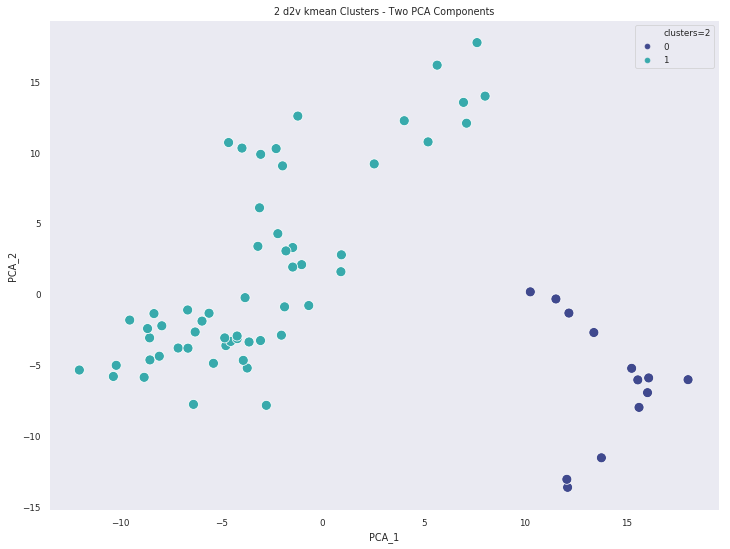


Avg Obs per cluster: 34.5

Number of observations per cluster:
1    56
0    13
dtype: int64
Time: 0.38695478439331055 seconds.

Number of Clusters: 4

Silhouette Score 4 clusters: 0.8144273119141157




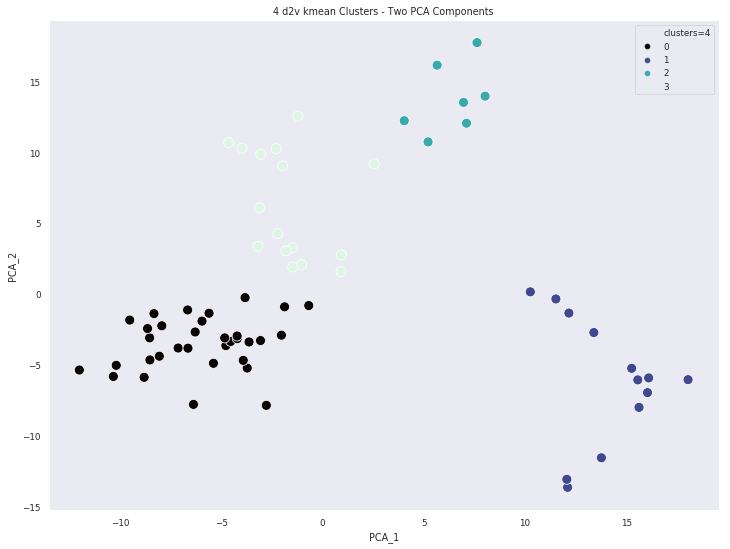


Avg Obs per cluster: 17.25

Number of observations per cluster:
0    33
3    16
1    13
2     7
dtype: int64
Time: 0.39673280715942383 seconds.

Number of Clusters: 6

Silhouette Score 6 clusters: 0.5381817711609503




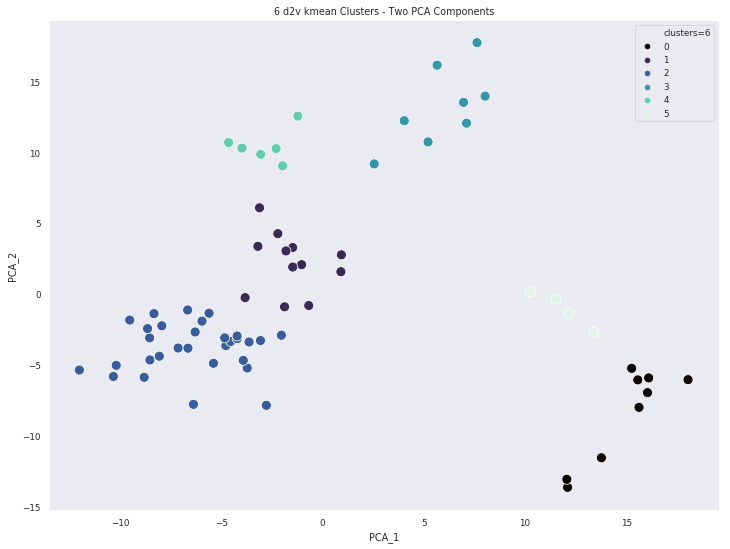


Avg Obs per cluster: 11.5

Number of observations per cluster:
2    30
1    12
0     9
3     8
4     6
5     4
dtype: int64
Time: 0.4205338954925537 seconds.

Number of Clusters: 8

Silhouette Score 8 clusters: 0.27321220588468054




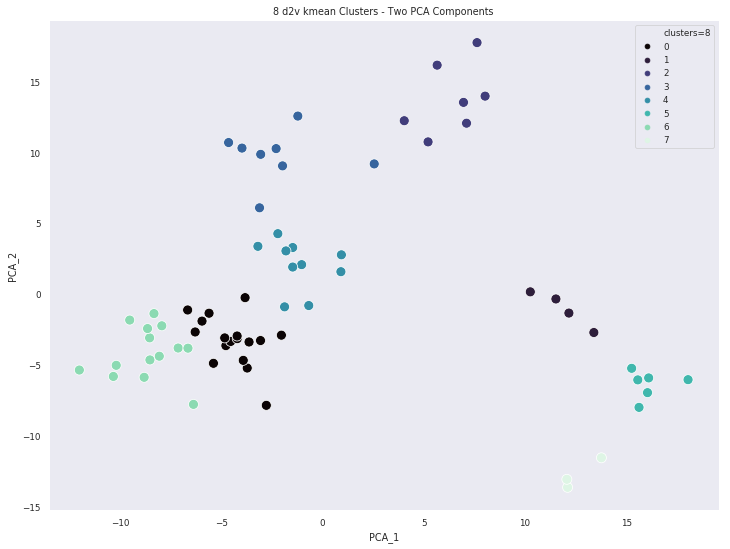


Avg Obs per cluster: 8.625

Number of observations per cluster:
0    17
6    14
4    10
3     8
2     7
5     6
1     4
7     3
dtype: int64
Time: 0.43985843658447266 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.1752175119329319




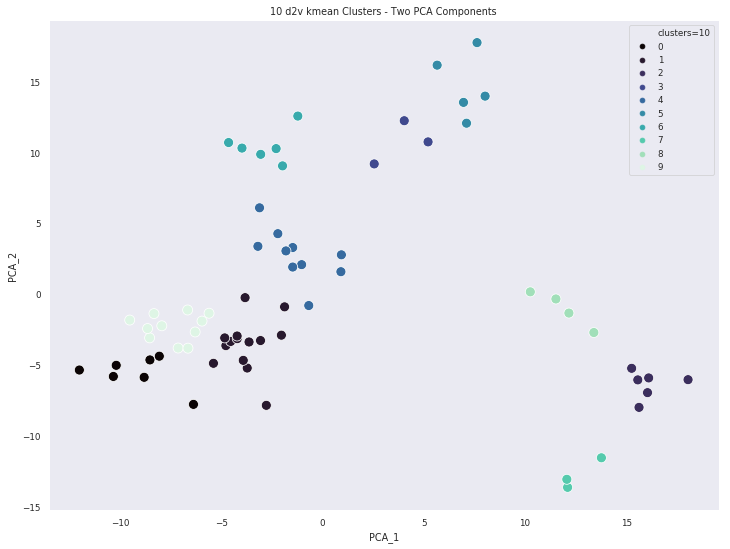


Avg Obs per cluster: 6.9

Number of observations per cluster:
1    14
9    11
4    10
0     7
6     6
2     6
5     5
8     4
7     3
3     3
dtype: int64
Time: 0.49241185188293457 seconds.

Number of Clusters: 12

Silhouette Score 12 clusters: 0.22238132478233413




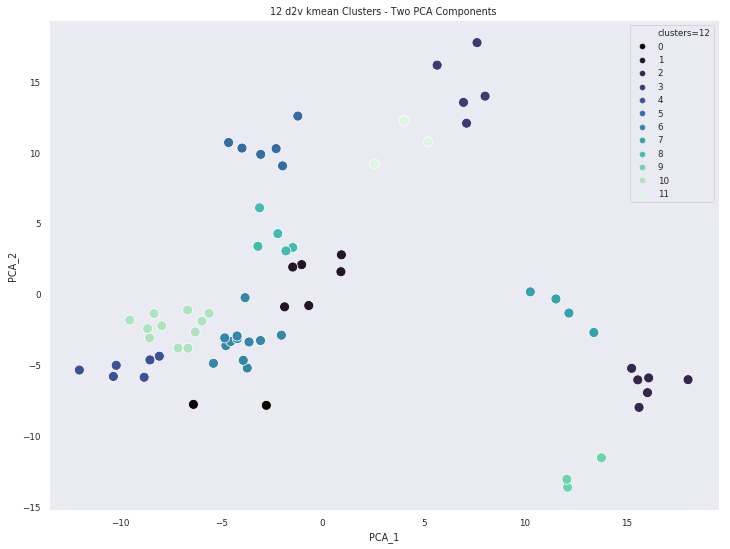


Avg Obs per cluster: 5.75

Number of observations per cluster:
6     12
10    11
5      6
4      6
2      6
1      6
8      5
3      5
7      4
11     3
9      3
0      2
dtype: int64
Time: 0.49786877632141113 seconds.

Number of Clusters: 14

Silhouette Score 14 clusters: 0.18444461635760778




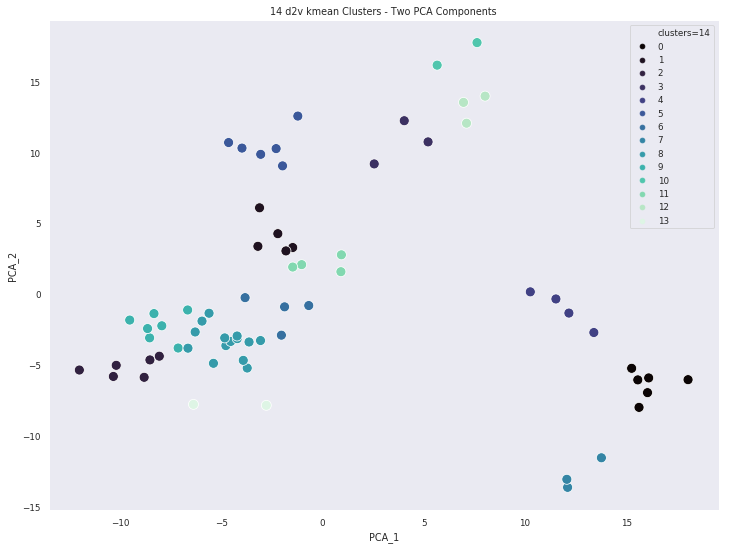


Avg Obs per cluster: 4.928571428571429

Number of observations per cluster:
8     14
9      7
5      6
2      6
0      6
1      5
11     4
6      4
4      4
12     3
7      3
3      3
dtype: int64
Time: 0.5199661254882812 seconds.



In [112]:
sns.set_context('paper')
d2v_fclusters = range(2,16,2)
for i in d2v_fclusters:
    t1 = time.time()
    d2v_fclusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Yf)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Yf, d2v_fclusters, metric='cosine'))
    print('\n')
    pca_fd2vclusters['clusters='+str(i)] = d2v_fclusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_fd2vclusters,palette='mako',legend='full',s=100)
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_fclusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_fclusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

In [113]:
#this loop iterates over a range of 10 to 46, in order to collect scores from each cluster
fnclusts =[]
fsscores = [] 
favgobs = []
fobsstd = []
for i in range(3,50,1):
    t1 = time.time()
    fd2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(vecs)    
    fnclusts.append(i)
    fsscores.append(silhouette_score(vecs, fd2v_clusters, metric='cosine'))
    favgobs.append(pd.value_counts(fd2v_clusters).mean())
    fobsstd.append(pd.value_counts(fd2v_clusters).std())
    print('N. Clusters: {}, done!'.format(i))

N. Clusters: 3, done!
N. Clusters: 4, done!
N. Clusters: 5, done!
N. Clusters: 6, done!
N. Clusters: 7, done!
N. Clusters: 8, done!
N. Clusters: 9, done!
N. Clusters: 10, done!
N. Clusters: 11, done!
N. Clusters: 12, done!
N. Clusters: 13, done!
N. Clusters: 14, done!
N. Clusters: 15, done!
N. Clusters: 16, done!
N. Clusters: 17, done!
N. Clusters: 18, done!
N. Clusters: 19, done!
N. Clusters: 20, done!
N. Clusters: 21, done!
N. Clusters: 22, done!
N. Clusters: 23, done!
N. Clusters: 24, done!
N. Clusters: 25, done!
N. Clusters: 26, done!
N. Clusters: 27, done!
N. Clusters: 28, done!
N. Clusters: 29, done!
N. Clusters: 30, done!
N. Clusters: 31, done!
N. Clusters: 32, done!
N. Clusters: 33, done!
N. Clusters: 34, done!
N. Clusters: 35, done!
N. Clusters: 36, done!
N. Clusters: 37, done!
N. Clusters: 38, done!
N. Clusters: 39, done!
N. Clusters: 40, done!
N. Clusters: 41, done!
N. Clusters: 42, done!
N. Clusters: 43, done!
N. Clusters: 44, done!
N. Clusters: 45, done!
N. Clusters: 46, d

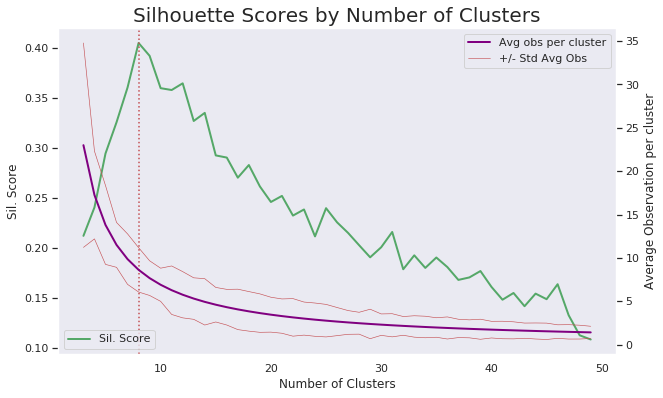

In [121]:
#Visualize Results
fobsstd1 = [ i+j for i,j in zip(favgobs,fobsstd)]
fstdneg = [ i-j for i,j in zip(favgobs,fobsstd)]

sns.set_context('notebook')
fig, ax = fig, ax = plt.subplots(figsize=(10,6))

ax2 = ax.twinx()
ax = sns.lineplot(fnclusts, fsscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(fnclusts, favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(fnclusts,fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(fnclusts,fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=8,color='r',linestyle='dotted')


ax.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.show()

Number of Clusters: 8

Silhouette Score 0.21069317535291246 clusters:




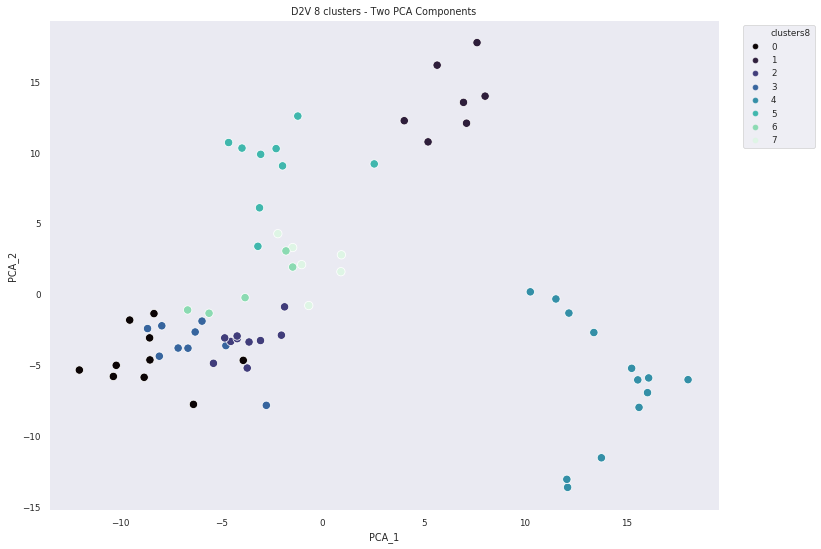

In [130]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

#fit transform doc2vec word vectors
Y8 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels
pca_8 = pd.DataFrame()
pca_8['original'] = X_train
pca_8['Professor'] = y_train[:,1]
pca_8['Subject'] = y_train[:,2]

pca_8['filename'] = y_train[:,0]

#cluster the data
d2v_clusters8 = cluster.KMeans(n_clusters=8, random_state=43).fit_predict(vecs) 
Y8 = pca.fit_transform(vecs)
pca_8['PCA_1'] = Y8[:,0]
pca_8['PCA_2'] = Y8[:,1]
print('Number of Clusters: 8')
# calculate and print silhouette average scores
print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y8, d2v_clusters8, metric='cosine')))
print('\n')
sns.set(context='paper',style='dark')
pca_8['clusters8'] = d2v_clusters8
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters8', data=pca_8,palette='mako',legend='full',
                s=70)
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 8 clusters - Two PCA Components")   
plt.show()

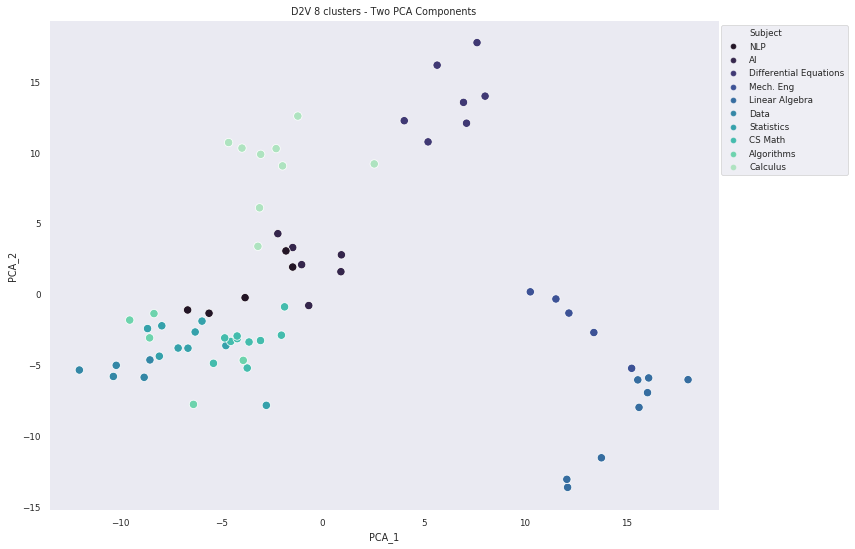

In [132]:
sns.set(context='paper',style='dark')
pca_8['clusters8'] = d2v_clusters8
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Subject', data=pca_8,palette='mako',legend='full',
                s=70)
plt.legend(loc='upper right', bbox_to_anchor=[1.2,1])
# label the axes and set the chart title  
plt.title("D2V 8 clusters - Two PCA Components")   
plt.show()

### Other features of Doc2Vec

- Doc2Vec has a method called .infer_vector(). Lets see we can use this as a classification method.
- We will once again extract the numerical vectors, calculate the cosign similarites with an infered vector.

In [ ]:
raw_data.head()

In [ ]:
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [ ]:
X_train.shape

In [ ]:
X_train[1][:50]

In [ ]:
d2v_vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])

In [ ]:
#this is a function that uses 'infer vector'. 
#fuction:
# adds the new sentence to the corpus
#recalculates the similarity and returns the 5 most similar sentences.

def lecture_search (text):
    new_sentence = word_tokenize(text.lower())
    
    #infer vector position from the model
    new_vector = model.infer_vector(new_sentence)
    
    #transpose the DF to append the new vector and transpose again
    d2vt = d2v_vecs.T
    d2vt[len(d2vt.columns)] = new_vector
    d2vtt = d2vt.T
    
    #Calculate new similarity matrix and add sentences and index and columns
    new_sents = list(X_train)
    new_sents.insert(0,text)
    new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)
    
    #extend len of lectures to include no title for new sentence
    lectures = list(subsprofs[2].reset_index(drop=True))
    lectures.insert(0,'new_sentence')
    
    #calculate mean similarity, insert to DF, insert lectures
    #new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
    new_sim.insert(0, 'lecture', lectures)
    
    return new_sim[[text,'lecture']].sort_values(by=[text],ascending=False)[:10]

In [ ]:
lecture_search('sometimes linear algebra is extremely cool')

In [ ]:
orig_text = "and address original question dog cat world diet drink make people fat"
new_sent = word_tokenize(orig_text.lower())
new_sent

In [ ]:
wvec = model.infer_vector(new_sent)

In [ ]:
d2vt = d2v_vecs.T
d2vt[len(d2vt.columns)] = wvec
d2vtt = d2vt.T
d2vtt.head()

In [ ]:
new_sents = list(X_train)
new_sents.insert(0,orig_text)

In [ ]:
new_sents

In [ ]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [ ]:
print(d2vt.shape)

print(d2vt.shape)


In [ ]:
d2vtt.shape

In [ ]:
new_sents = list(X_train)

In [ ]:
new_sents.insert(0,orig_text)

In [ ]:
new_sents

In [ ]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [ ]:
lectures = list(subsprofs[2].reset_index(drop=True))
lectures.insert(0,'new_sent')

In [ ]:
new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
new_sim.insert(0, 'lecture', lectures)

In [ ]:
new_sim[[orig_text,'lecture','mean_similarity']].sort_values(by=[orig_text],ascending=False)[:5]

In [ ]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

In [ ]:
top_sents = new_sim.sort_values(by='mean_similarity',ascending=False)\
        [:10][['lecture', 'mean_similarity']]

In [ ]:
test_df = new_sim[[orig_text,'lecture']]
test_df.head()

In [ ]:
test_df.sort_values(by=orig_text,ascending=False)

In [ ]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [ ]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

In [ ]:
new_sim[:orig_text]

In [ ]:
top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]

In [ ]:
model.most_similar('so problem choice h prime k hash function work chain')

In [ ]:
len(new_sents)

In [ ]:

v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])